# MAST387 Final Project
## Student: Tristan, Lafleur (40245238)

### Problem A
### This exercise deals with sparse recovery, a popular signal processing technique that allows one to reconstruct signals (such as, e.g., images) from linear measurements. It has applications in many areas, including medical imaging (e.g., MRI). A vector is called s-sparse if it has at most s nonzero entries.

In [36]:
import numpy
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-dark')


#### 1. Create a function `sparse_data()` that takes as input integers s, N, and d, and returns a dataset of d random N-dimensional s-sparse vectors. The s-sparse vectors composing the dataset should be generated independently as follows. For each vector, first generate a random subset of s unique elements from {1, . . . , N}. Then, populate the corresponding entries with s independent random variables distributed according to the standard distribution N(0, 1). 

In [37]:
def sparse_data(_s:int, _N:int, _d:int):
    result = numpy.zeros((_d, _N))
    
    rng = numpy.random.default_rng()
    
    for i in range(_d):
        non_zero_set = rng.choice(numpy.arange(1, _N), _s, replace=False)

        vector = numpy.random.randn(_s)
        result[i, non_zero_set] = vector

    return result


#### 2. Print the output of sparse data(s=4, N=10, d=5).

In [38]:
sparse_data(4, 10, 5)


array([[ 0.        , -0.40620628,  0.        ,  0.        ,  1.94978702,
         0.        ,  0.        ,  1.58906551,  1.00025343,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.19769036,  1.08108136,
         0.        , -0.39409189,  0.        , -1.6636142 ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1.25572157,
         0.13721058,  0.95658313,  0.        ,  0.        , -0.47285456],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.26365027,  0.5200091 , -0.32133734,  0.        , -0.42464171],
       [ 0.        ,  1.02557393,  0.        ,  0.        , -1.07649913,
        -0.04302347,  0.50240318,  0.        ,  0.        ,  0.        ]])

#### 3. Implement the Matching Pursuit (MP) algorithm with a function `MP()`

In [39]:
def MP(_A:numpy.ndarray, _y:numpy.ndarray, _K:int):
    N = _A.shape[1]

    approx = numpy.zeros((1,N))

    for k in range(1, _K):
        r_k = _y - _A.dot(approx[-1]).reshape(-1,1)
        
        buffer = numpy.zeros(N)
        for j in range(N):
            buffer[j] = numpy.abs(_A[:, j].T.dot(r_k)).item()

        j_k = numpy.argmax(buffer)

        e_jk = numpy.eye(N)[:, j_k]

        x_k = approx[-1] + (_A[:, j_k].dot(r_k)) * e_jk
        approx = numpy.vstack((approx, x_k))

    return approx.T


#### 4. Test the MP algorithm on the data stored in `sparse_A.npy` and `sparse_y.npy` with K = 2s, where s is the number of nonzero entries of the ground truth signal x, stored in sparse x.npy. Visualize the ground truth signal x and its MP approximation xˆ in the same plot using `matplotlib.pyplot.stem()`. Compute the relative approximation error with respect to the 2-norm.

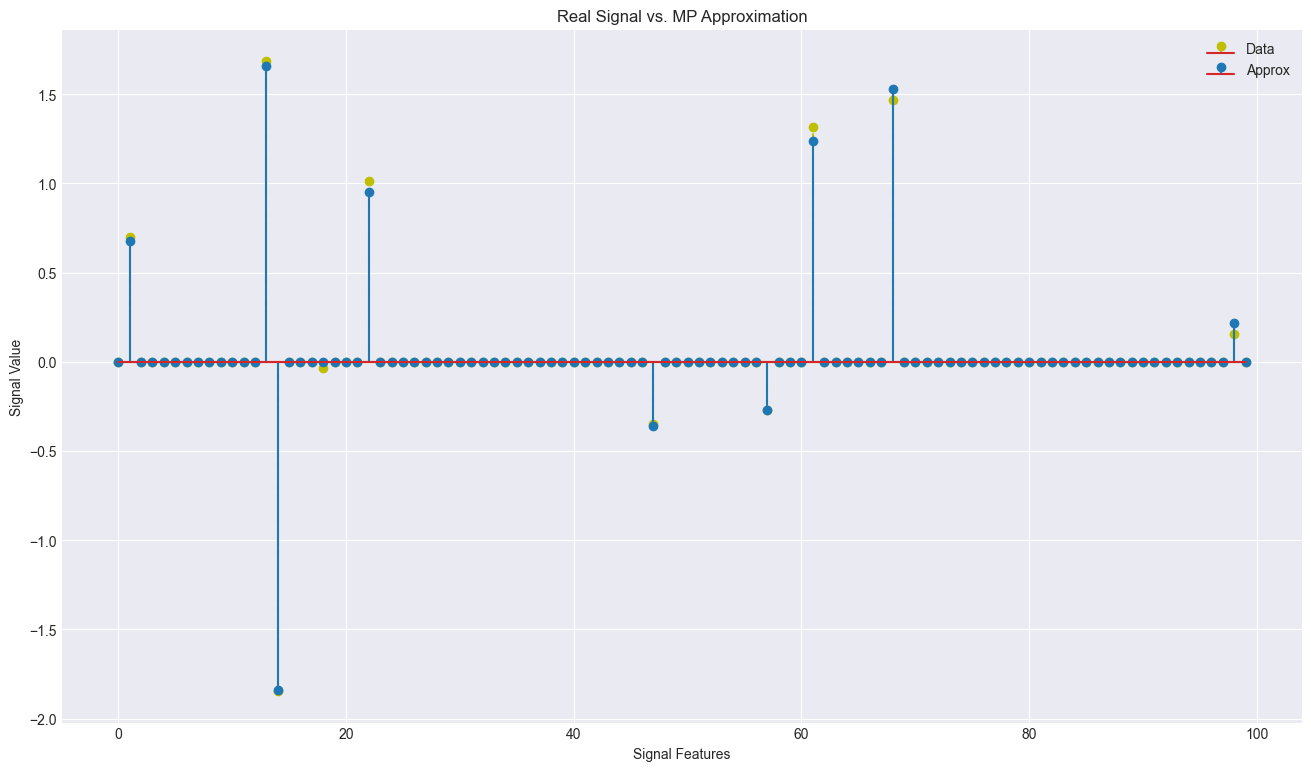

The error produced by the approximation is 0.0401


In [55]:
sparse_A = numpy.load("sparse_A.npy")

sparse_y = numpy.load("sparse_y.npy")

sparse_x = numpy.load("sparse_x.npy")
K = 2 * (sparse_x != 0).sum()
signal_approx = MP(sparse_A, sparse_y, K)
x_hat = signal_approx.T[-1]

plt.figure(figsize=(16,9))

plt.stem(range(len(sparse_x)), sparse_x, linefmt="--y", label="Data")
plt.stem(range(len(x_hat)), x_hat, label="Approx")

plt.xlabel("Signal Features")
plt.ylabel("Signal Value")
plt.title("Real Signal vs. MP Approximation")

plt.legend()

plt.grid(True)

plt.show()

error = numpy.linalg.norm(sparse_x.reshape(-1) - x_hat, ord=2) / numpy.linalg.norm(sparse_x.reshape(-1), ord=2)
print(f"The error produced by the approximation is {error:.4f}")


#### 5. In the same setting as part 4, plot the relative approximation error as a function of the iteration k. What do you observe? 

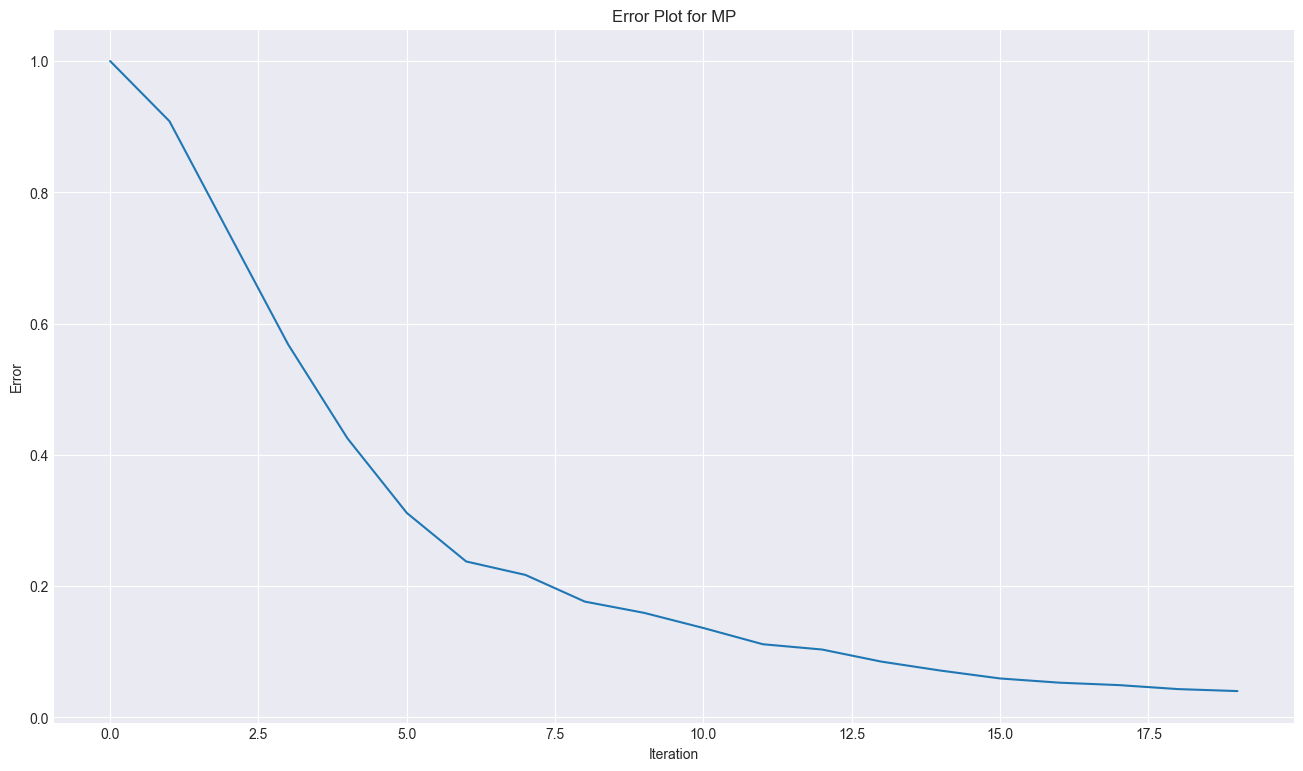

In [56]:
all_errors = []
for i in range(len(signal_approx.T)):
    all_errors.append(numpy.linalg.norm(sparse_x.reshape(-1) - signal_approx.T[i], ord=2) / numpy.linalg.norm(sparse_x.reshape(-1), ord=2))

plt.figure(figsize=(16,9))

plt.plot(all_errors)

plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Error Plot for MP")

plt.grid(True)

plt.show()


- From the plot above, it seems that the matching pursuit algorithm converges to a a set error with respect to the 2-norm. This suggests that given enough iterations, the matching pursuit algorithm can create very accurate signal approximations.

#### 6. Implement the Orthogonal Matching Pursuit (OMP) algorithm with a function `OMP()`.

In [42]:
def OMP(_A:numpy.ndarray, _y:numpy.ndarray, _K:int):
    N = _A.shape[1]

    approx = numpy.zeros((1,N))

    S = set()

    for k in range(1, _K):
        r_k = _y - _A.dot(approx[-1]).reshape(-1,1)
        
        buffer = numpy.zeros(N)
        for j in range(N):
            buffer[j] = numpy.abs(_A[:, j].T.dot(r_k)).item()

        j_k = numpy.argmax(buffer)
        S = S.union([j_k])
        z_k = numpy.linalg.lstsq(_A[:, list(S)], _y)[0]

        x_k = numpy.zeros(N)
        for i, s in enumerate(list(S)):
            x_k[s] = z_k[i]

        approx = numpy.vstack((approx, x_k.reshape((1,N))))

    return approx.T


#### 7. Repeat part 4 for OMP.

C:\Users\Trim\AppData\Local\Temp\ipykernel_20120\1931146858.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_k[s] = z_k[i]


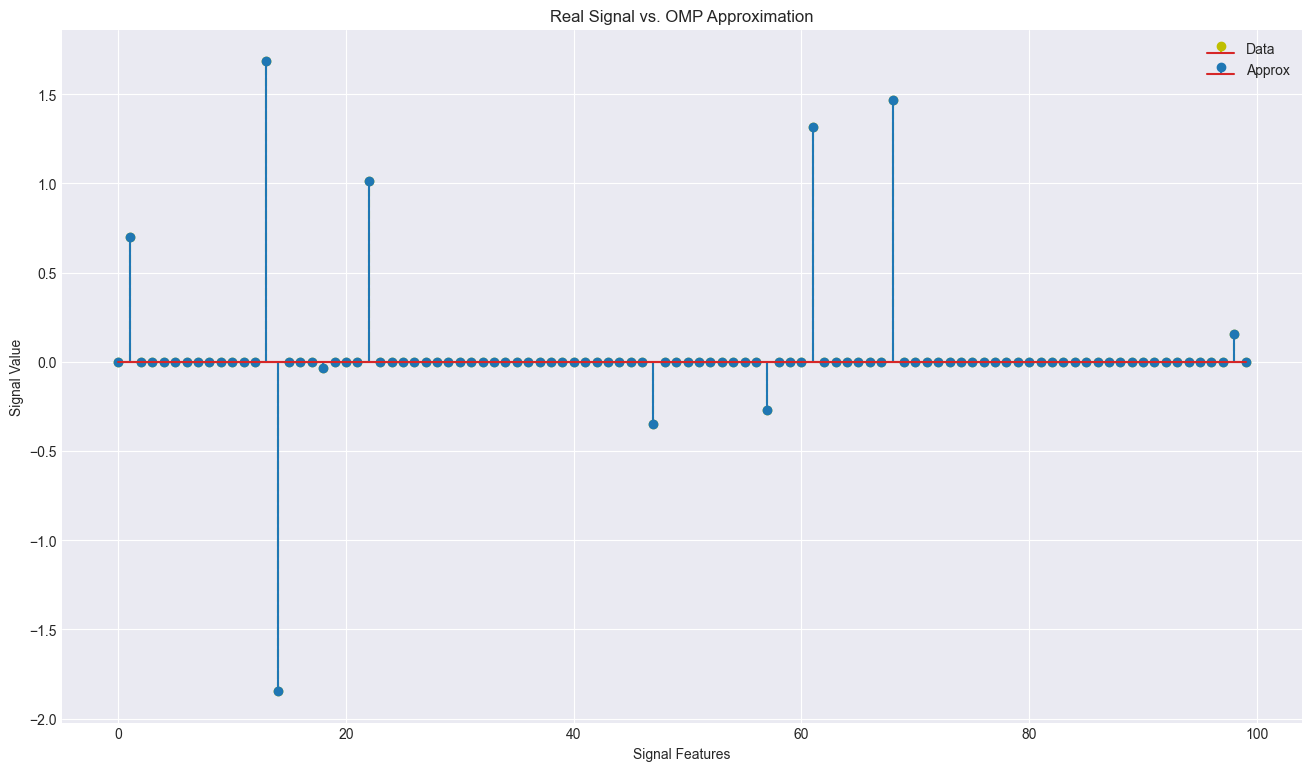

The error produced by the approximation is 0.0000


In [54]:
omp_signal_approx = OMP(sparse_A, sparse_y, K)
x_hat_omp = omp_signal_approx.T[-1]

plt.figure(figsize=(16,9))

plt.stem(range(len(sparse_x)), sparse_x, linefmt="--y", label="Data")
plt.stem(range(len(x_hat_omp)), x_hat_omp, label="Approx")

plt.xlabel("Signal Features")
plt.ylabel("Signal Value")
plt.title("Real Signal vs. OMP Approximation")

plt.legend()

plt.grid(True)

plt.show()

error = numpy.linalg.norm(sparse_x.reshape(-1) - x_hat_omp, ord=2) / numpy.linalg.norm(sparse_x, ord=2)
print(f"The error produced by the approximation is {error:.4f}")


#### 8. Compare the convergence of MP and OMP as a function of the iteration. Which method performs better?

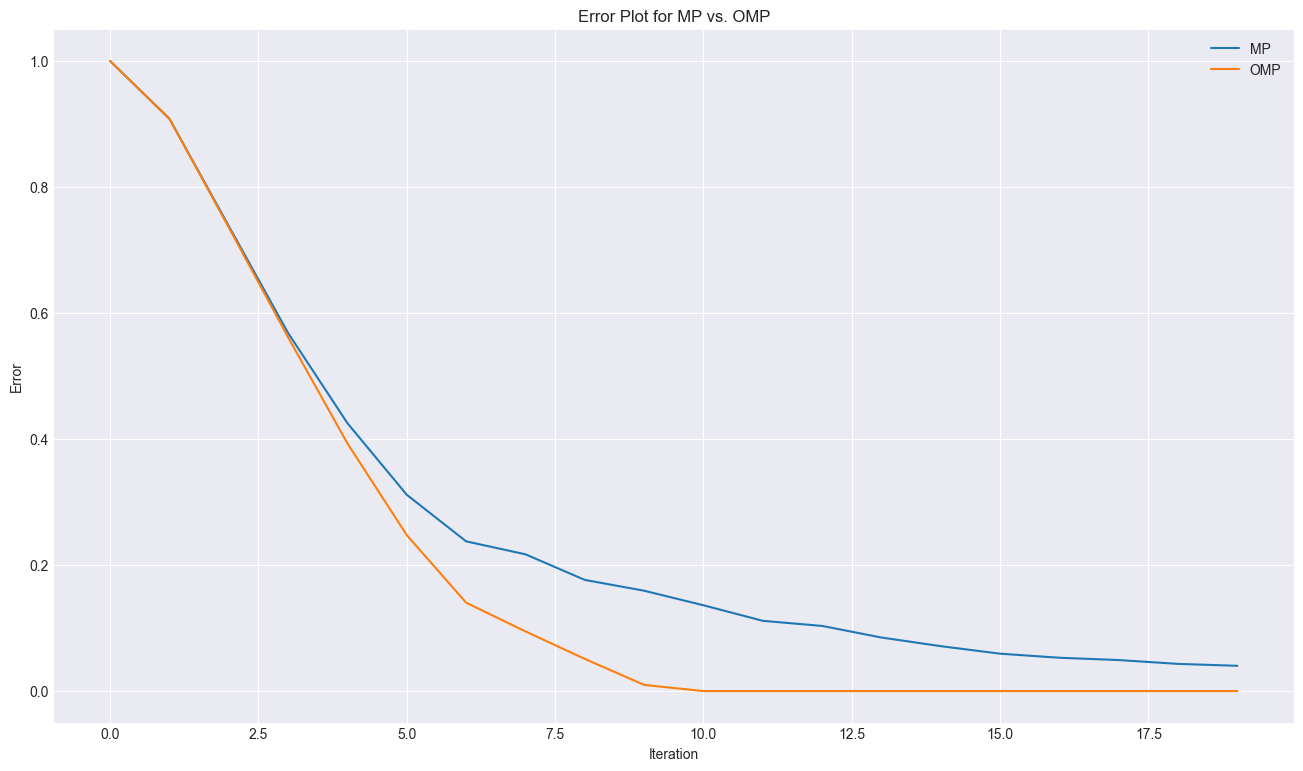

In [57]:
omp_all_errors = []
for i in range(len(omp_signal_approx.T)):
    omp_all_errors.append(numpy.linalg.norm(sparse_x.reshape(-1) - omp_signal_approx.T[i], ord=2) / numpy.linalg.norm(sparse_x.reshape(-1), ord=2))

plt.figure(figsize=(16,9))

plt.plot(all_errors, label="MP")
plt.plot(omp_all_errors, label="OMP")

plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Error Plot for MP vs. OMP")

plt.legend()

plt.grid(True)

plt.show()


- Comparing the plots for the approximations, it would seem that the OMP algorithm performs better due to faster convergence and more accurate approximations. This may be because OMP is a greedy algorithm and leverages solutions to vectors in the data rather than simply approximate the distribution.

### Problem B
### This problem deals with image compression. We will compare the SVD-based compression we studied in class with a different method based on wavelet decomposition. 

In [14]:
from PIL import Image
import numpy
import matplotlib.pyplot as plt
import skimage
import pywt
import math
from sklearn.decomposition import PCA

plt.style.use('seaborn-v0_8-dark')


#### 1. Load the image from the file image phantom.bmp and visualize it. This is the SheppLogan phantom (https://en.wikipedia.org/wiki/Shepp-Logan_phantom). It is a simplified model of the human head used in medical imaging tests.

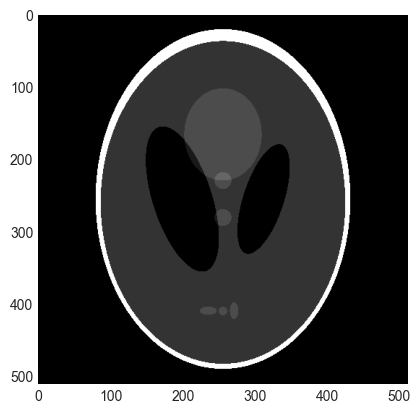

In [2]:
img = numpy.array(Image.open("image_phantom.bmp"), dtype=numpy.float32)
plt.imshow(img, cmap="gray", vmin=0, vmax=255)

plt.show()


#### 2. Using `scikit-image`, resize the image to a 64 × 64 size (without using antialiasing), store it in a matrix called img and visualize it. From now on, we will work with this resized 64 × 64 version. 

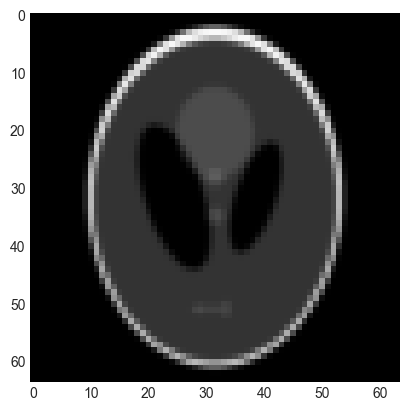

In [3]:
img = skimage.transform.resize(img, (64,64))
plt.imshow(img, cmap="gray", vmin=0, vmax=255)

plt.show()


#### 3. Compute the SVD of img and study its singular values. What do you observe?

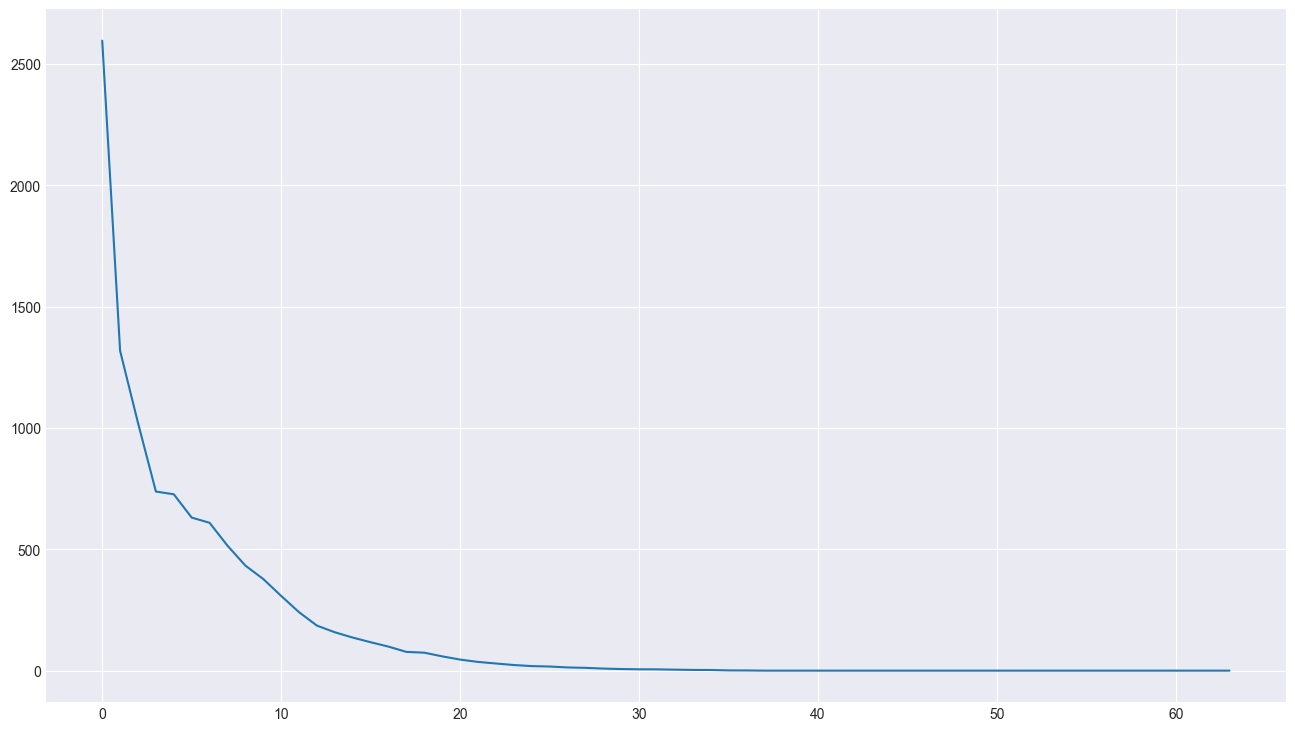

In [4]:
svd_deco = numpy.linalg.svd(img, True)

plt.figure(figsize=(16,9))

plt.plot(svd_deco.S)

plt.grid(True)

plt.show()


- From the plot of the singular values, it appears that the values drop off very quickly, resulting in a large chunk of the values being orders of magnitude smaller that the first handful. For the purposes of image compression, this means that only a small amount of singular values can be used to compress the image with a reasonable result. This is because the large singular values can be interpreted as having the most significant directions of the data in the image while the comparatively smaller ones contribute very little. Rescaling the image according to the those important directions can effectively capture variance and relationships.

#### 4. How many singular values do you need to explain 95% of the image variance? Plot the corresponding compressed image.

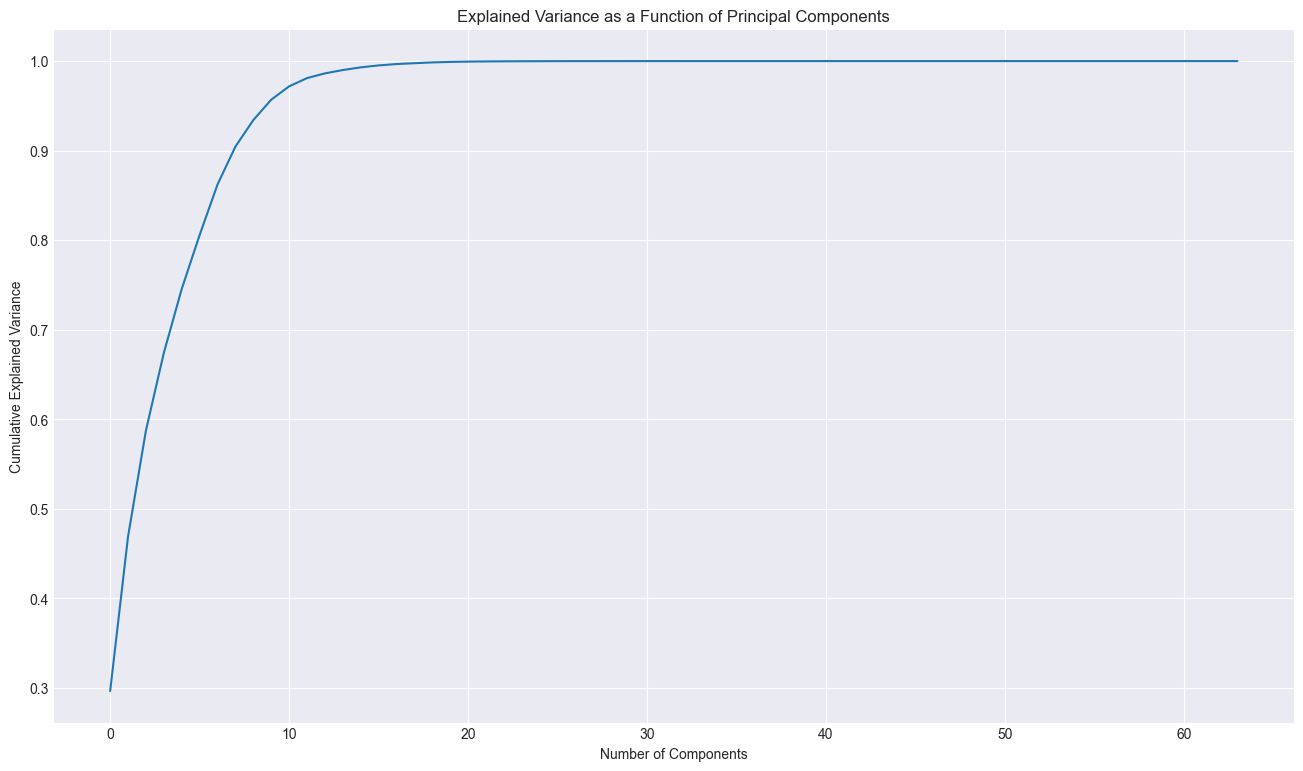

In [21]:
pca = PCA().fit(img)

plt.figure(figsize=(16,9))

plt.plot(numpy.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');
plt.title("Explained Variance as a Function of Principal Components")

plt.grid(True)

plt.show()


- From the PCA plot shown, the 95% of the explained variance of the image may be covered by about 8 singular values.

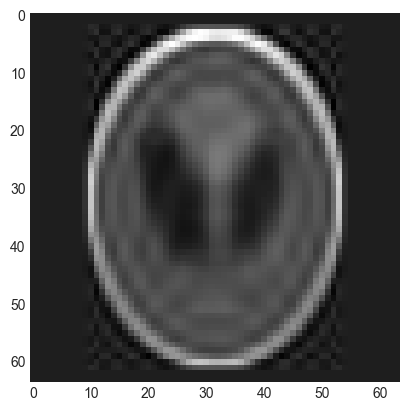

In [20]:
k = 8
compressed_img = svd_deco.U[:, :k] @ numpy.diag(svd_deco.S[:k]) @ svd_deco.Vh[:k, :]
plt.imshow(compressed_img, cmap="gray")

plt.show()


#### 5. Compute the wavelet decomposition of `img` and then its reconstruction `img_reco`. Plot `img_reco` and compute the reconstruction error, given by the Frobenius norm of the difference `img` − `img_reco`. Is the reconstruction error acceptable? 

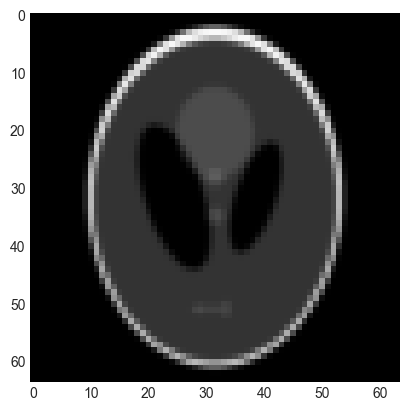

The reconstruction error is 0.0010


In [6]:
wave_deco = pywt.wavedec2(img, "haar", mode="symmetric", axes=(-2, -1))
img_reco = pywt.waverec2(wave_deco, "haar", mode="symmetric", axes=(-2, -1))

plt.imshow(img_reco, cmap="gray", vmin=0, vmax=255)

plt.show()

error = numpy.linalg.norm(img - img_reco, "fro")
print(f"The reconstruction error is {error:.4f}")


- From the reconstruction error, it seems that the error is in fact acceptable as it is close to 0

#### 6. Now, we want to visualize the wavelet decomposition of `img`. This will require some data manipulation since the output `wave_deco` of `pywt.wavedec2()` is stored in a very specific format. Display the horizontal, vertical, and diagonal details at levels 2, 4, 6 of `img`. 

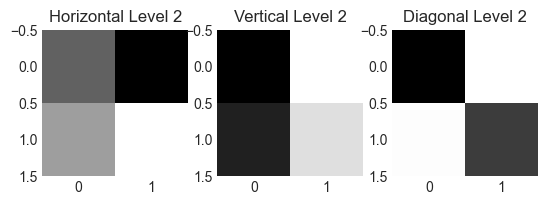

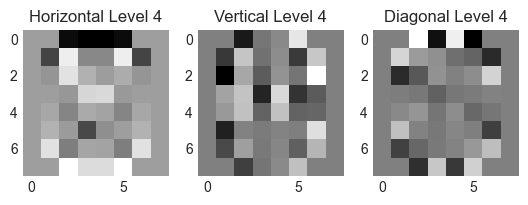

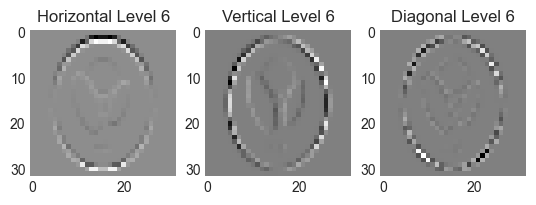

In [7]:
for level_details in [2,4,6]:
    fig, ax = plt.subplots(1, 3)

    ax[0].imshow(wave_deco[level_details][0], cmap="gray")
    ax[1].imshow(wave_deco[level_details][1], cmap="gray")
    ax[2].imshow(wave_deco[level_details][2], cmap="gray")

    ax[0].set_title(f"Horizontal Level {level_details}")
    ax[1].set_title(f"Vertical Level {level_details}")
    ax[2].set_title(f"Diagonal Level {level_details}")

    plt.show()


#### 7. Create a function called `from_deco_to_img()` that takes a wavelet decomposition wave deco as input and returns as output a 2D NumPy array called `deco_img`.

In [8]:
def from_deco_to_img(_wave_deco:list):
    img_size = 2**(len(_wave_deco) - 1)
    deco_img = numpy.zeros((img_size, img_size))
    deco_img[0,0] = _wave_deco[0].item()

    for i in range(1, len(_wave_deco[1:]) + 1):
        deco_img[0:2**(i - 1), 2**(i - 1):2**i] = _wave_deco[i][0]
        deco_img[2**(i - 1):2**i, 0:2**(i - 1)] = _wave_deco[i][1]
        deco_img[2**(i - 1):2**i, 2**(i - 1):2**i] = _wave_deco[i][2]

    return deco_img


#### 8. Test `from_deco_to_img()` on the wave deco tuple obtained in part 5. Visualize the corresponding image `deco_img`. You should get an image with most of the information in the top left corner. To enhance visibility, visualize also a suitable transformation of `deco_img`. 

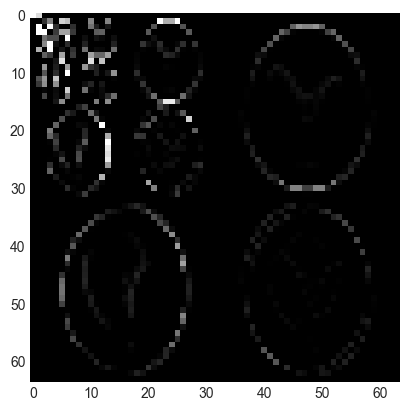

In [27]:
deco_img = from_deco_to_img(wave_deco)

plt.imshow(deco_img, cmap="gray", vmin=0, vmax=255)

plt.show()



#### 9. Repeat part 8 a 32 × 32 resized version of `img`.

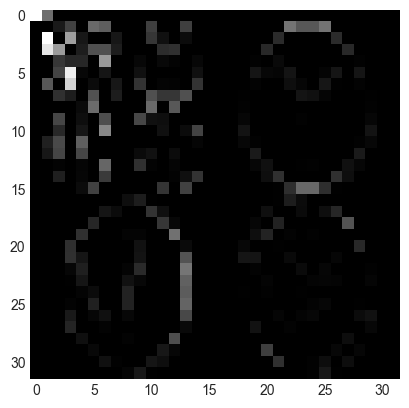

In [28]:
resized_img = skimage.transform.resize(img, (32,32))
resized_wave_deco = pywt.wavedec2(resized_img, "haar", mode="symmetric", axes=(-2,-1))
resized_deco_img = from_deco_to_img(resized_wave_deco)
plt.imshow(resized_deco_img, cmap="gray", vmin=0, vmax=255)

plt.show()



#### 10. Reshape the matrix `deco_img` into a vector called `deco_vec`. This vector represents the wavelet coefficients of the image. First, plot the entries of `deco_vec` using `matplotlib.pyplot.stem()`. Then, plot the absolute wavelet coefficients, sorted in descending order, using a curve plot. Do they seem to decay fast?

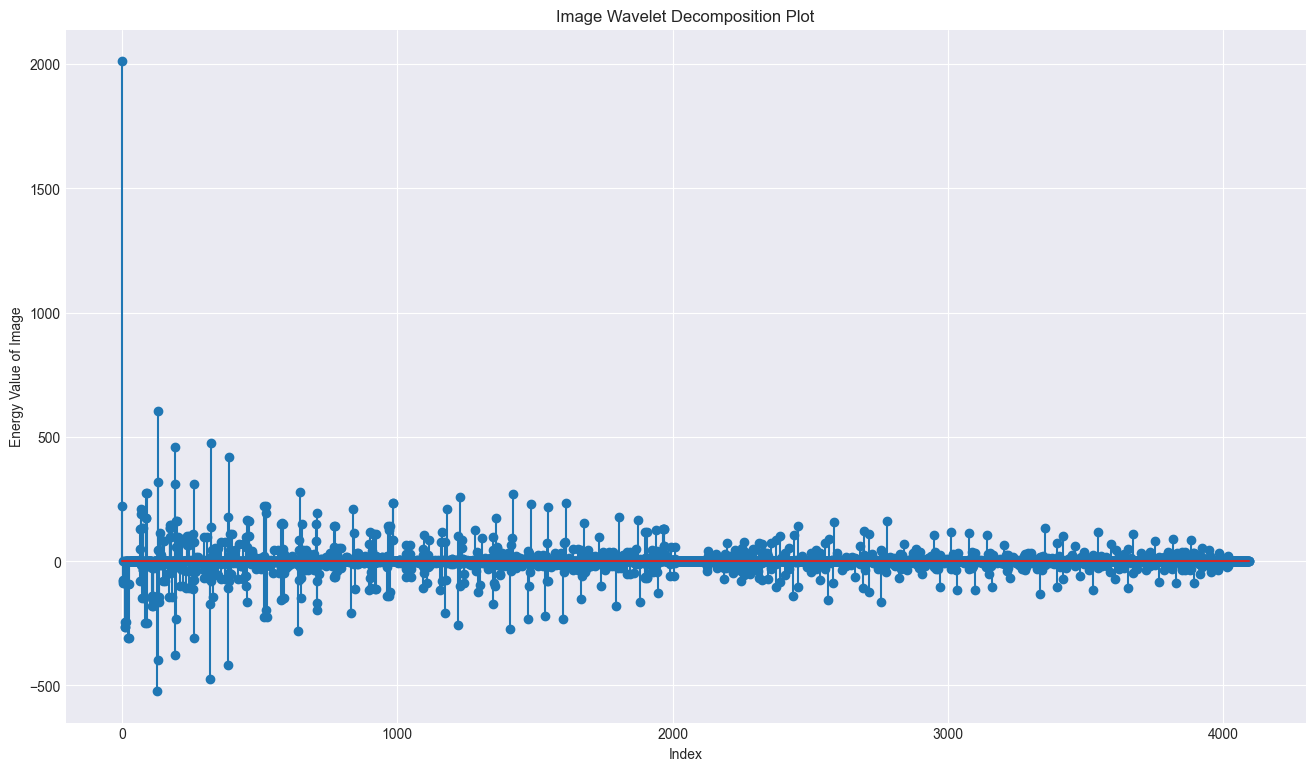

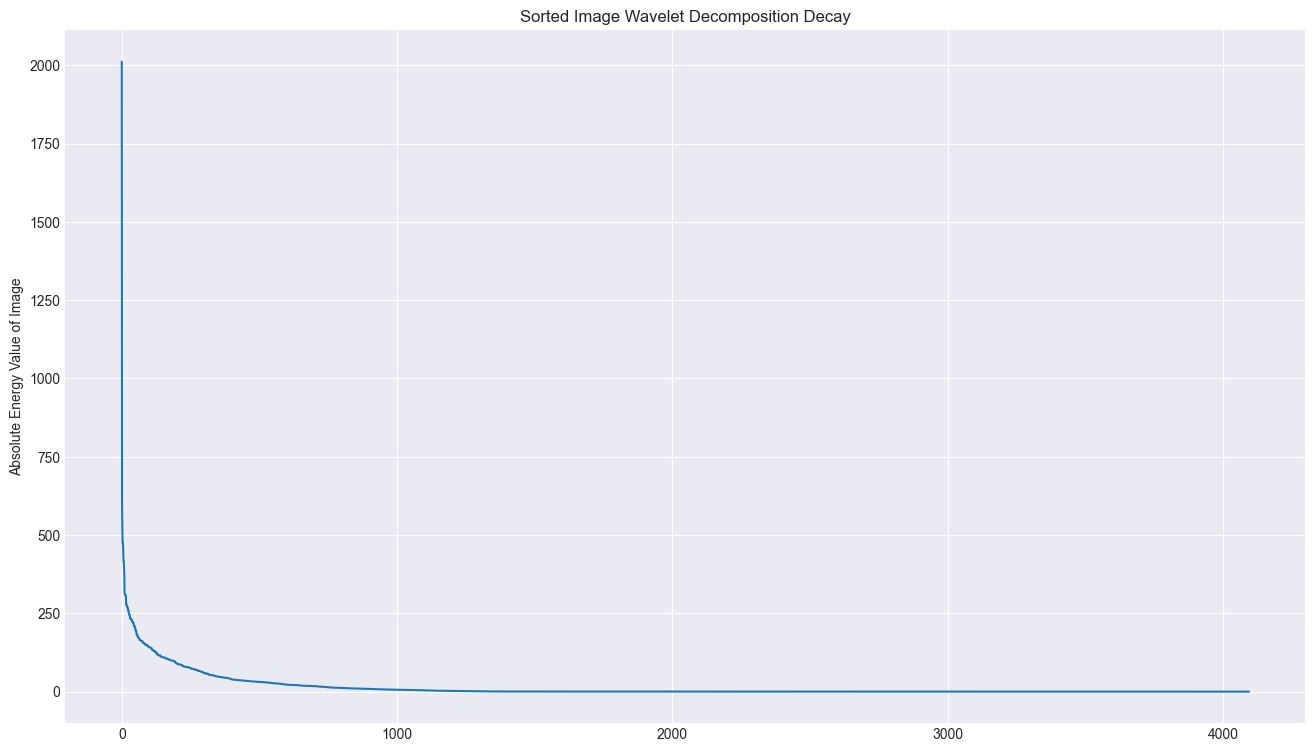

In [11]:
deco_vec = deco_img.reshape(-1)

plt.figure(figsize=(16,9))

plt.stem(deco_vec)

plt.xlabel("Index")
plt.ylabel("Energy Value of Image")
plt.title("Image Wavelet Decomposition Plot")

plt.grid(True)

plt.show()

sorted_deco_img = numpy.sort(numpy.abs(deco_vec))[::-1]

plt.figure(figsize=(16,9))

plt.plot(sorted_deco_img)

plt.ylabel("Absolute Energy Value of Image")
plt.title("Sorted Image Wavelet Decomposition Decay")

plt.grid(True)

plt.show()


- From the plot shown regarding the compression decay, it seems that the image compression does decay quickly when sorting the values. Like SVD, this seems to suggest that we may only require a small amount of these wavelet coefficients to compress the image as shown in the previous plots.

#### 11. Finally, let’s create a plot to compare the decay of the absolute wavelet coefficients and the decay of the singular values of the image, as a function of the memory used (measured as the number of scalars stored) by each compression method. In the case of wavelet coefficients, plot the kth largest absolute wavelet coefficient as a function of the number of scalars needed to store k wavelet coefficients (see explanation in part 10). In the case of singular values, plot the kth singular value as a function of the amount of memory used to store the first k singular values and singular vectors. Which compression method seems to be most memory efficient? 

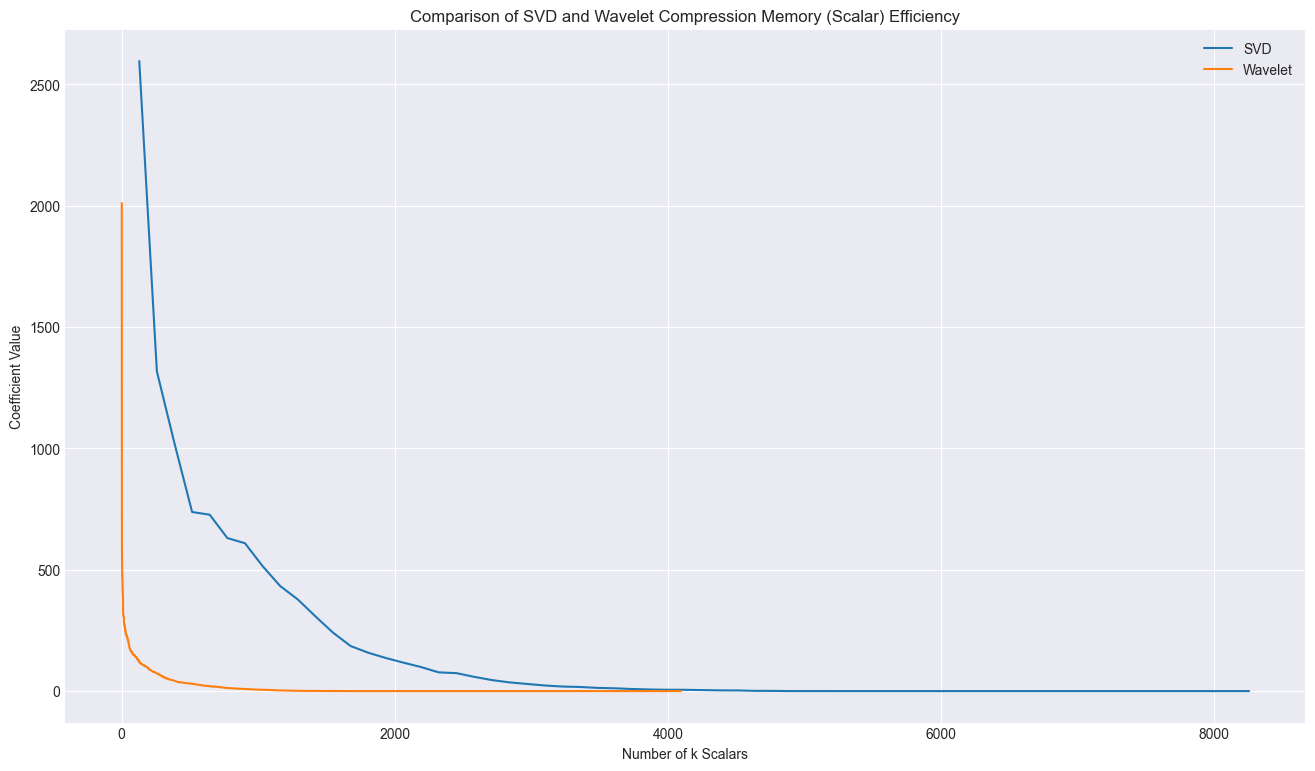

In [34]:
plt.figure(figsize=(16,9))

svd_memory = [i + i * svd_deco.U.shape[0] + i * svd_deco.Vh.shape[0] for i in range(1, len(svd_deco.S) + 1)]
plt.plot(svd_memory, svd_deco.S, label="SVD")

plt.plot(numpy.arange(1, len(sorted_deco_img) + 1), sorted_deco_img, label="Wavelet")

plt.xlabel("Number of k Scalars")
plt.ylabel("Coefficient Value")
plt.title("Comparison of SVD and Wavelet Compression Memory (Scalar) Efficiency")

plt.legend()

plt.grid(True)

plt.show()


- From the plot shown above, it seems that wavelet compression is more memory efficient with respect to the coefficients it needs to store. This is because the SVD algorithm requires information about the matrix itself as it decomposes a matrix into left and right singular vectors scaled by the singular values. As such, SVD requires memory for each of those components.

### Problem C
### In this problem, we will consider a dataset containing different features and the sale price of several houses. The files associated with this problem are house info.txt, house train.csv and house test.csv. 

In [73]:
import pandas
import matplotlib.pyplot as plt
import numpy
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

plt.style.use('seaborn-v0_8-dark')


#### 1. Load the dataset `house_train.csv` into a DataFrame called `df_train`. In the following exercises, we will work with df train, unless stated otherwise.

In [74]:
df_train = pandas.read_csv("house_train.csv", index_col="Id")
df_train


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,20,RL,63.0,8500,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,CollgCr,Norm,Norm,1Fam,1Story,7,5,2004,2004,Gable,CompShg,VinylSd,VinylSd,BrkFace,106.0,Gd,TA,PConc,Gd,TA,Av,Unf,0,Unf,0,1422,1422,GasA,Ex,Y,SBrkr,1422,0,0,1422,0,0,2,0,3,1,Gd,7,Typ,0,NaN,Attchd,2004.0,RFn,2,626,TA,TA,Y,192,60,0,0,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal,179600
1446,85,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,SFoyer,6,5,1966,1966,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,Gd,LwQ,187,Rec,627,0,814,GasA,Gd,Y,SBrkr,913,0,0,913,1,0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1990.0,Unf,1,240,TA,TA,Y,0,0,252,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,129000
1447,20,RL,NaN,26142,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1962,1962,Gable,CompShg,HdBoard,HdBoard,BrkFace,189.0,TA,TA,CBlock,TA,TA,No,Rec,593,Unf,0,595,1188,GasA,TA,Y,SBrkr,1188,0,0,1188,0,0,1,0,3,1,TA,6,Typ,0,NaN,Attchd,1962.0,Unf,1,312,TA,TA,P,261,39,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,157900


#### 2. Provide an overview of `df_train`. How many categorical/numerical features are there? Which columns contain missing values? What percentage of the data is missing in those columns? Is there any other interesting aspect worth noting? Use suitable visualization strategies to illustrate. 

In [75]:
def place_bar_labels(_list: list):
    for i in range(len(_list)):
        plt.text(i, _list[i], _list[i], ha = 'center')


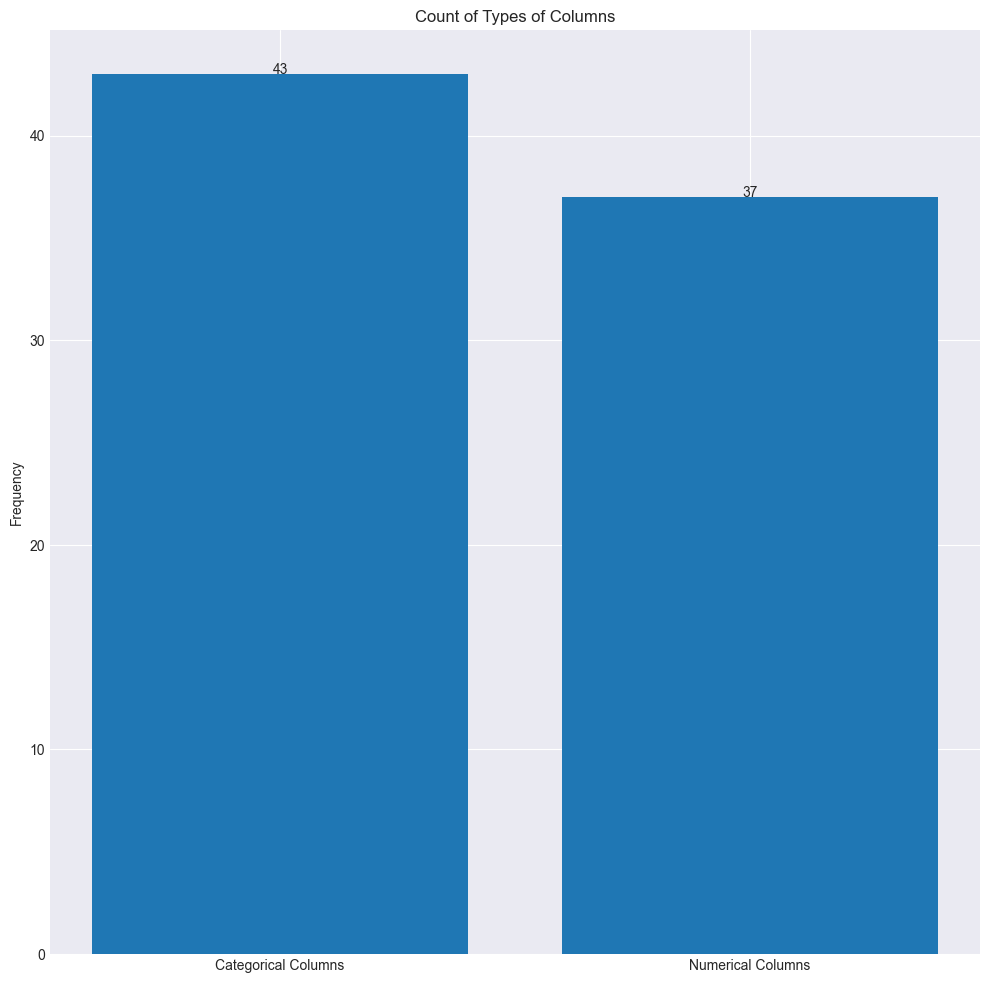

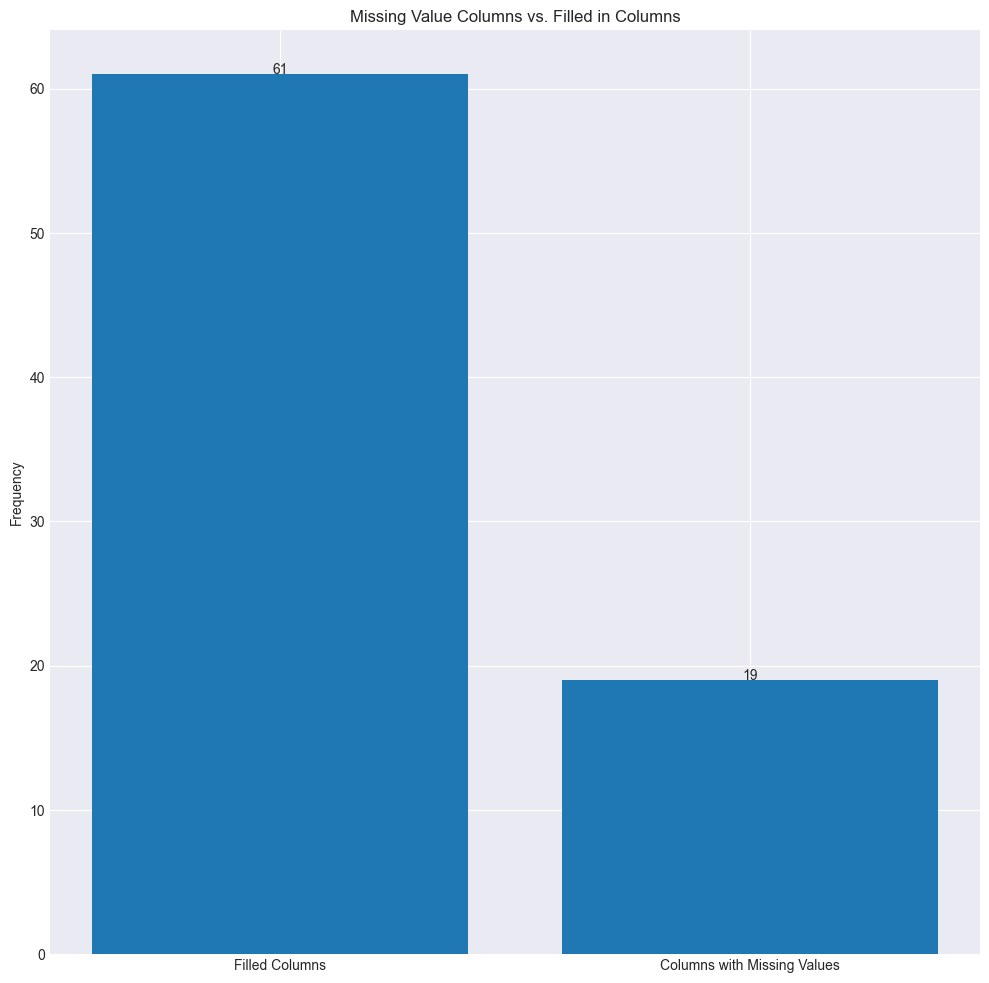

LotFrontage     0.178744
Alley           0.937888
MasVnrType      0.596273
MasVnrArea      0.005521
BsmtQual        0.025535
BsmtCond        0.025535
BsmtExposure    0.026225
BsmtFinType1    0.025535
BsmtFinType2    0.026225
Electrical      0.000690
FireplaceQu     0.471360
GarageType      0.053830
GarageYrBlt     0.053830
GarageFinish    0.053830
GarageQual      0.053830
GarageCond      0.053830
PoolQC          0.995169
Fence           0.807453
MiscFeature     0.963423
dtype: float64


In [76]:
num_num_col = len(df_train._get_numeric_data().columns)
num_cate_col = len(df_train.columns) - num_num_col
col_list = [num_cate_col, num_num_col]

plt.figure(figsize=(12,12))

plt.bar(["Categorical Columns", "Numerical Columns"], col_list)

plt.ylabel("Frequency")

plt.title("Count of Types of Columns")

place_bar_labels(col_list)

plt.grid(True)

missing_val_col = df_train.columns[df_train.isna().any()]
num_empty_val_col = len(missing_val_col)
num_filled_col = len(df_train.columns) - num_empty_val_col
col_list = [num_filled_col, num_empty_val_col]

plt.figure(figsize=(12,12))

plt.bar(["Filled Columns", "Columns with Missing Values"], col_list)

plt.ylabel("Frequency")

plt.title("Missing Value Columns vs. Filled in Columns")

place_bar_labels(col_list)

plt.grid(True)

plt.show()

miss_val_df = df_train.loc[:, df_train.isna().any()]
perc_miss_val = miss_val_df.isna().sum() / len(miss_val_df)
print(perc_miss_val)


- From the sumarry it may be surmised that a somewhat even split of categorical and numerical columns and about 25% of the coilumns contain missing values, some more than others. In particular, the fields `MiscFeature`, `Fence`, `PoolQC` and `Alley` have a lot of missing features. This may inform us that these features are very situational and don't contribute much to explaining the data.

#### 3. Using an appropriate visualization strategy, show the distribution of `SalePrice` values. Define a new column called `SalePriceLog` containing the log10 transformation of `SalePrice`. What is the effect of this transformation on the distribution?

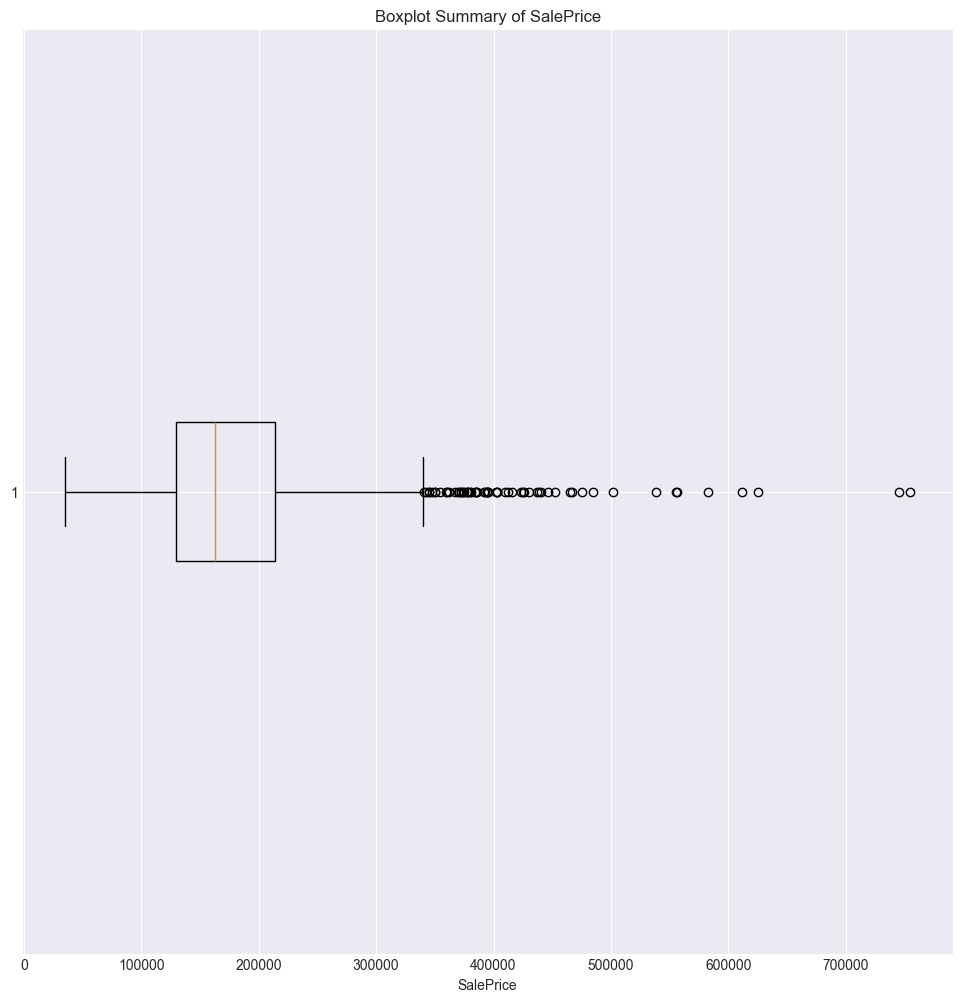

Numercial Summary of SalePrice

count      1449.000000
mean     181003.610076
std       79558.841800
min       34900.000000
25%      129900.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


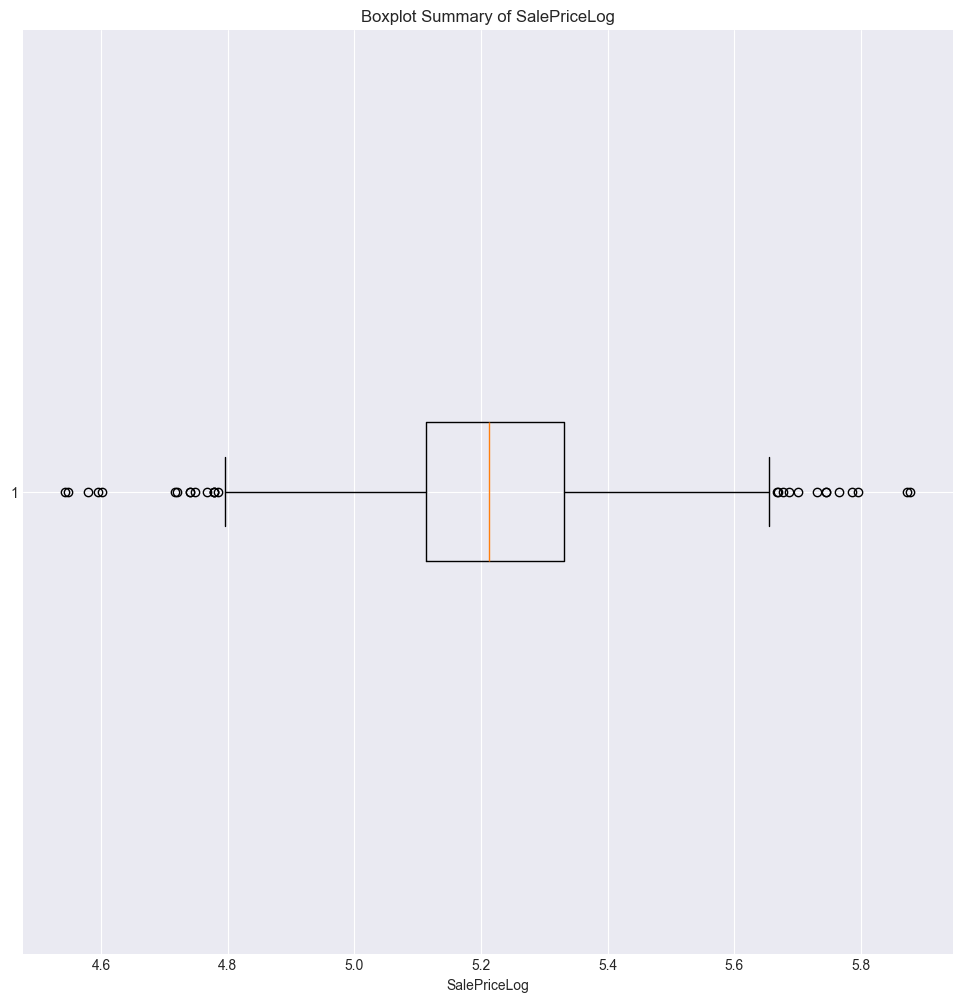

Numercial Summary of SalePriceLog

count    1449.000000
mean        5.222130
std         0.173576
min         4.542825
25%         5.113609
50%         5.212188
75%         5.330414
max         5.877947
Name: SalePriceLog, dtype: float64


In [77]:
plt.figure(figsize=(12,12))

plt.boxplot(df_train.SalePrice, vert=False)

plt.xlabel("SalePrice")
plt.title("Boxplot Summary of SalePrice")

plt.grid(True)

plt.show()

print("Numercial Summary of SalePrice\n")
print(df_train.SalePrice.describe())

df_train["SalePriceLog"] = numpy.log10(df_train.SalePrice)

plt.figure(figsize=(12,12))

plt.boxplot(df_train.SalePriceLog, vert=False)

plt.xlabel("SalePriceLog")
plt.title("Boxplot Summary of SalePriceLog")

plt.grid(True)

plt.show()

print("Numercial Summary of SalePriceLog\n")
print(df_train.SalePriceLog.describe())


- Applying the logarithm ends up having the data become a bit more uniform and allows less outliers to appear. This may benefit us such that the data may impact relationships less and maintain a better understanding as well.

#### 4. Plot `SalePrice` as a function of `YearBuilt`. What do you observe?

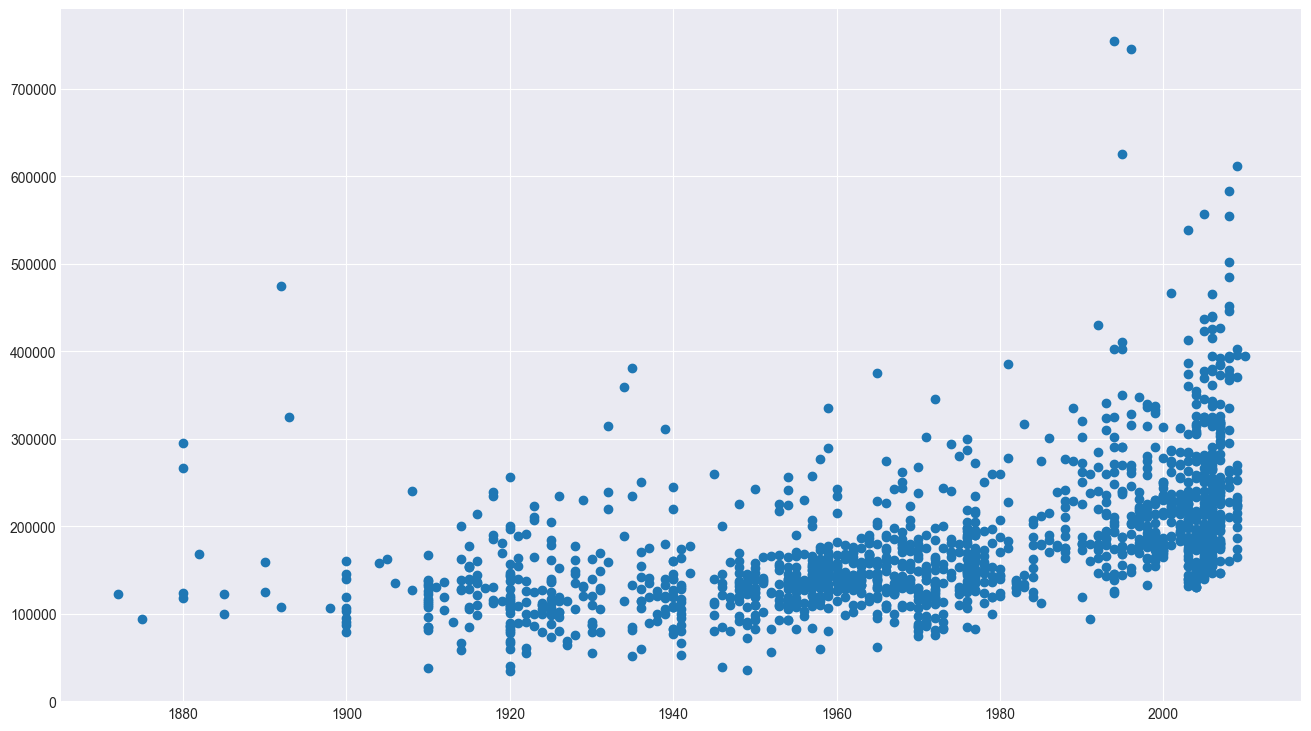

In [78]:
plt.figure(figsize=(16,9))

plt.scatter(df_train.YearBuilt, df_train.SalePrice)

plt.grid(True)

plt.show()


- From the plot above, it seems that the prices of houses follow a trend of increasing as the years go by, with outliers always existing regardless of the year. This may suggest that it may be a relevant field to utilize and is correlated with `SalePrice`.

#### 5. Define a DataFrame called `df_by_zone` that has `MSZoning` as index and `MSSubClass`, `YearBuilt`, `YearRemodAdd`, `GarageType`, `Fence`, and `SaleCondition` as columns. The values should be computed either as the mean value (for numerical variables) or the most frequent value (for categorical variables) of the corresponding column, for different values of `MSZoning`. Print the DataFrame.

In [95]:
df_by_zone = df_train.groupby("MSZoning").agg({ "MSSubClass": "mean", "YearBuilt": "mean", "YearRemodAdd": "mean", "GarageType": pandas.Series.mode, "Fence": pandas.Series.mode, "SaleCondition": pandas.Series.mode })
df_by_zone.MSSubClass = df_by_zone.MSSubClass.astype(int)
df_by_zone.YearBuilt = df_by_zone.YearBuilt.astype(int)
df_by_zone.YearRemodAdd = df_by_zone.YearRemodAdd.astype(int)
df_by_zone


,MSSubClass,YearBuilt,YearRemodAdd,GarageType,Fence,SaleCondition
MSZoning,,,,,,
C (all),56,1924,1958,Detchd,MnPrv,Abnorml
FV,91,2004,2004,Attchd,GdWo,Normal
RH,80,1945,1971,Detchd,MnPrv,Normal
RL,49,1975,1985,Attchd,MnPrv,Normal
RM,84,1942,1976,Detchd,MnPrv,Normal


#### 6. Let’s do some data cleaning. Create a DataFrame `df_train_filled` from `df_train`, where missing values are replaced with values that you deem appropriate. Explain the rationale behind your data-filling strategy, while taking into account the information provided in `house_info.txt`. Print the values of `df_train_filled` relative to the columns `PoolQC`, `MiscFeature`, `LotFrontage`, `GarageYrBlt` and `MasVnrArea` and the indices 234 and 287. 

In [80]:
miss_val_df.columns


Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')

- Any categorical columns that contain NaN values will be filled in according to what the info file states a N/A category should be (ex. MasVnrType has None as the N/A category). This aligns with what the actual NA values should be according to the info file while helping with categorical encoding.
- Any numerical columns with NaN will have their missing values filled in as 0 or 0.0 if it is a real valued number. This would help to provide frameworks like sklearn to better handle training.

In [81]:
miss_val_df.loc[miss_val_df.MasVnrType.isnull(), 'MasVnrType'] = "None"
miss_val_df.loc[miss_val_df.Alley.isnull(), 'Alley'] = "NA"
miss_val_df.loc[miss_val_df.BsmtQual.isnull(), 'BsmtQual'] = "NA"
miss_val_df.loc[miss_val_df.BsmtCond.isnull(), 'BsmtCond'] = "NA"
miss_val_df.loc[miss_val_df.BsmtExposure.isnull(), 'BsmtExposure'] = "NA"
miss_val_df.loc[miss_val_df.BsmtFinType1.isnull(), 'BsmtFinType1'] = "NA"
miss_val_df.loc[miss_val_df.BsmtFinType2.isnull(), 'BsmtFinType2'] = "NA"
miss_val_df.loc[miss_val_df.FireplaceQu.isnull(), 'FireplaceQu'] = "NA"
miss_val_df.loc[miss_val_df.GarageType.isnull(), 'GarageType'] = "NA"
miss_val_df.loc[miss_val_df.GarageFinish.isnull(), 'GarageFinish'] = "NA"
miss_val_df.loc[miss_val_df.GarageCond.isnull(), 'GarageCond'] = "NA"
miss_val_df.loc[miss_val_df.PoolQC.isnull(), 'PoolQC'] = "NA"
miss_val_df.loc[miss_val_df.Fence.isnull(), 'Fence'] = "NA"
miss_val_df.loc[miss_val_df.MiscFeature.isnull(), 'MiscFeature'] = "NA"

miss_val_df.loc[miss_val_df.LotFrontage.isnull(), 'LotFrontage'] = 0.0
miss_val_df.loc[miss_val_df.MasVnrArea.isnull(), 'MasVnrArea'] = 0.0
miss_val_df.loc[miss_val_df.GarageYrBlt.isnull(), 'GarageYrBlt'] = 0.0

df_train_filled = df_train
df_train_filled = df_train_filled.fillna(miss_val_df)


In [82]:
df_train_filled[df_train_filled.index == 234]


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
234,20,RL,75.0,10650,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,Norm,1Fam,1Story,5,6,1976,1976,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,Gd,Av,LwQ,182,ALQ,712,0,894,GasA,TA,...,SBrkr,894,0,0,894,1,0,1,0,3,1,TA,5,Typ,0,NA,Attchd,1976.0,Unf,1,308,TA,TA,Y,365,0,0,0,0,0,NA,MnPrv,NA,0,2,2010,WD,Normal,128200,5.107888


In [83]:
df_train_filled[df_train_filled.index == 287]


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,...,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SalePriceLog
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
287,50,RL,77.0,9786,Pave,NA,IR1,Bnk,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1.5Fin,6,7,1962,1981,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,600,Unf,0,312,912,GasA,TA,...,SBrkr,1085,649,0,1734,0,0,1,1,3,1,Gd,7,Typ,1,Gd,Attchd,1962.0,RFn,2,440,TA,TA,Y,0,0,0,0,128,0,NA,GdPrv,NA,0,6,2006,WD,Normal,159000,5.201397


#### 7. Plot `SalePriceLog` as a function of every other relevant numerical variable (i.e., excluding `SalePrice` and `Id`) and show the corresponding linear regression curves. From a visual inspection, what are the numerical variables that seem most linearly correlated with `SalePriceLog`?

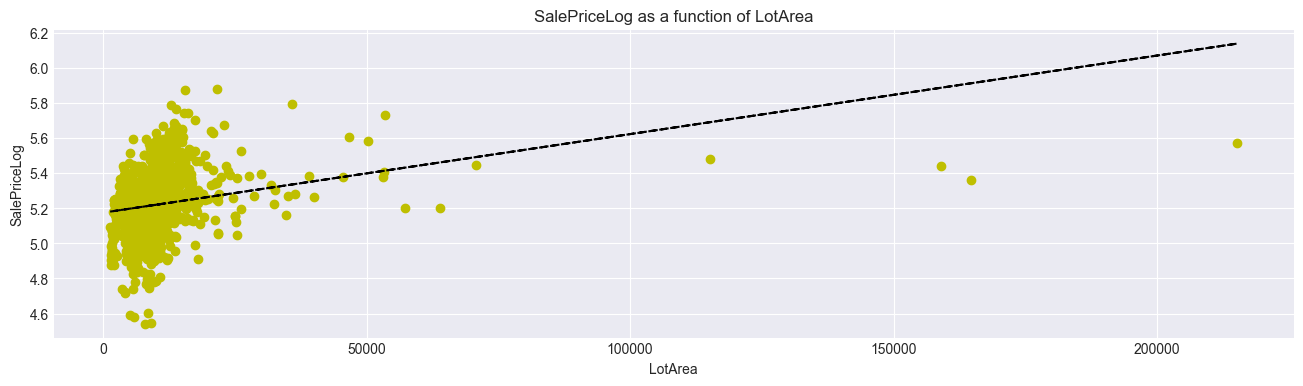

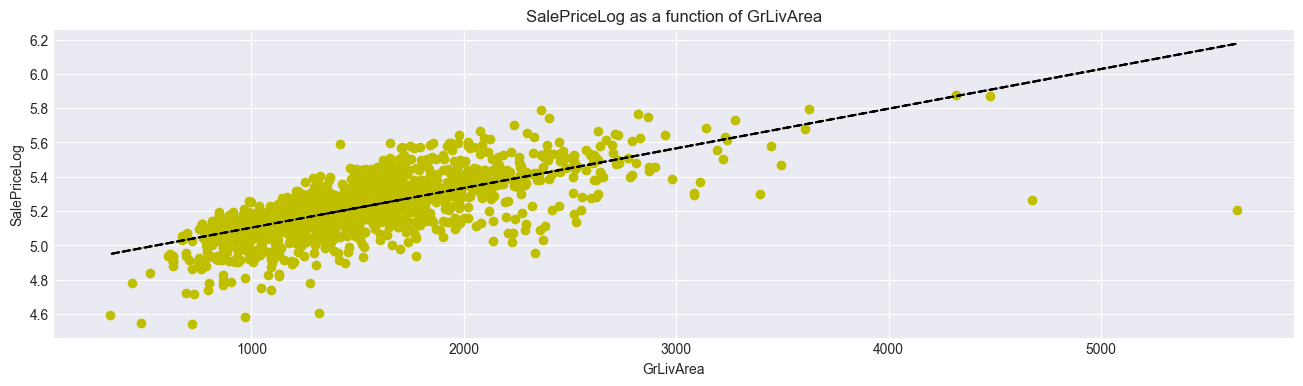

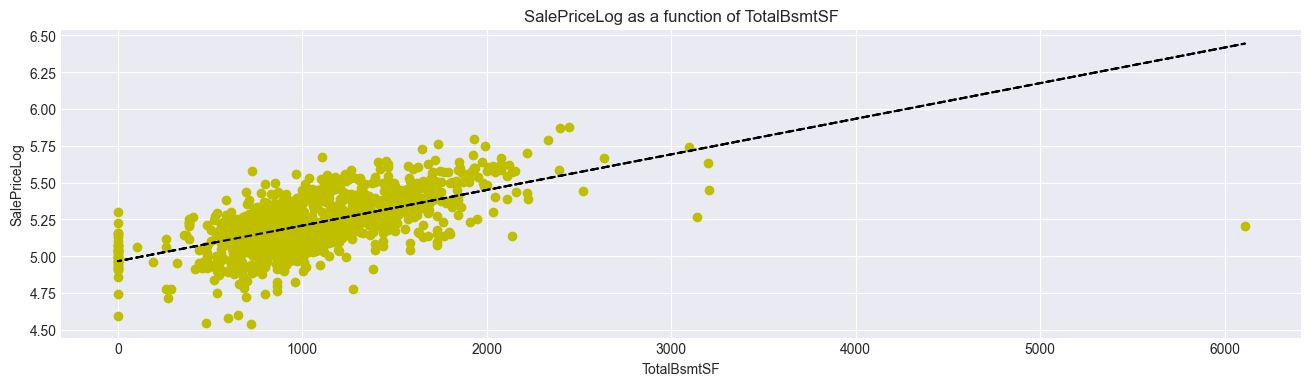

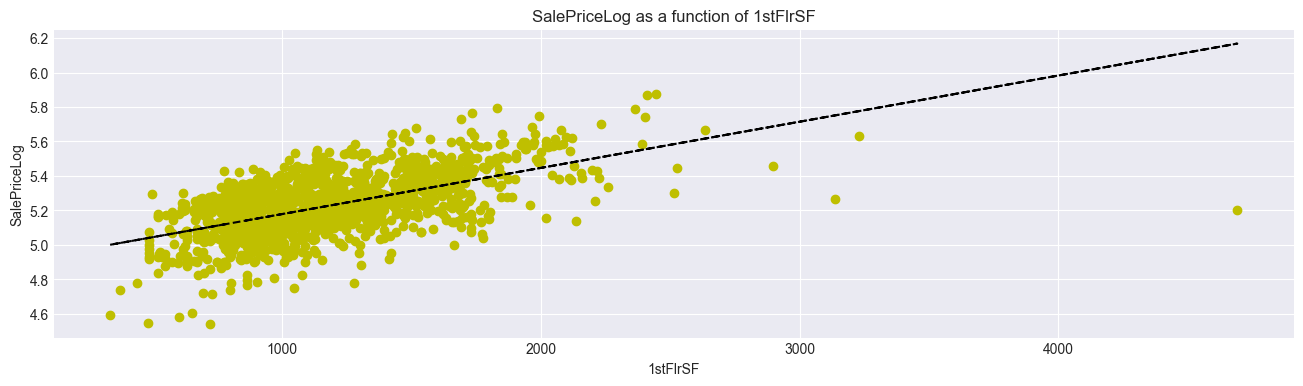

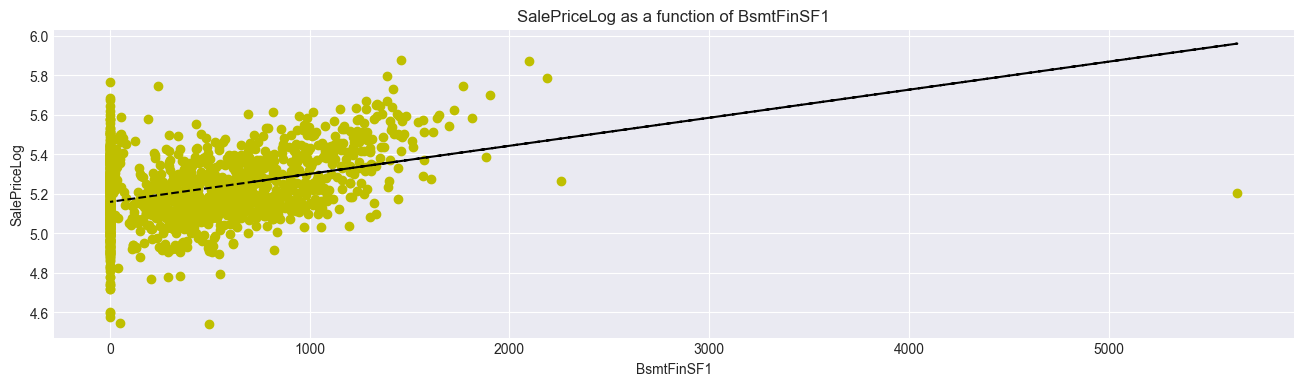

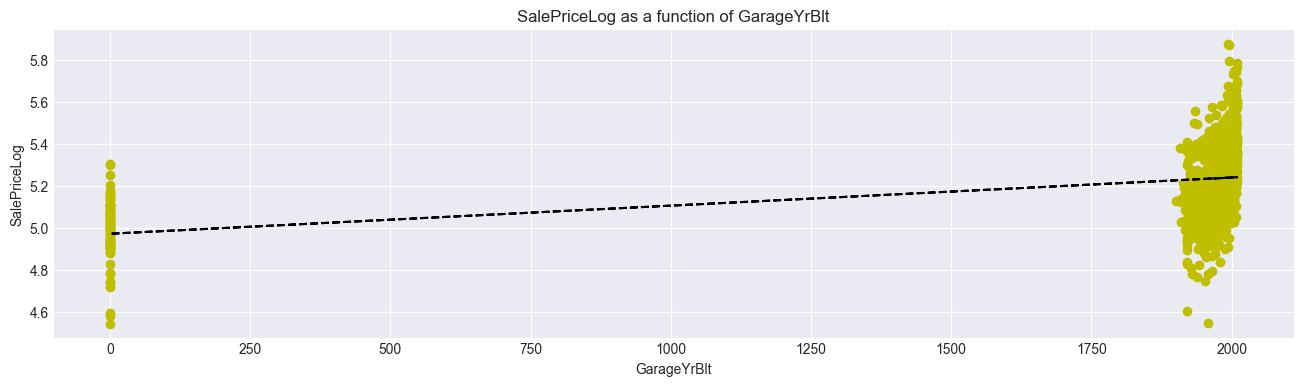

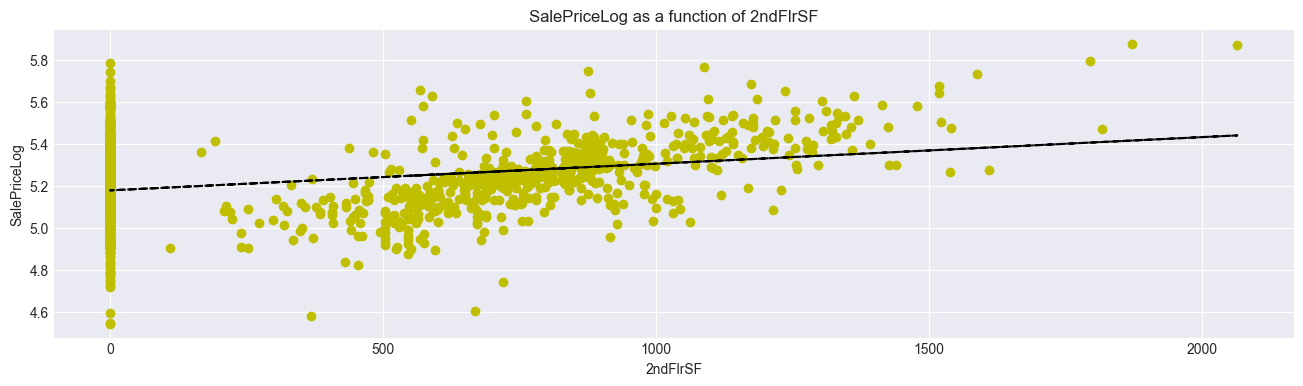

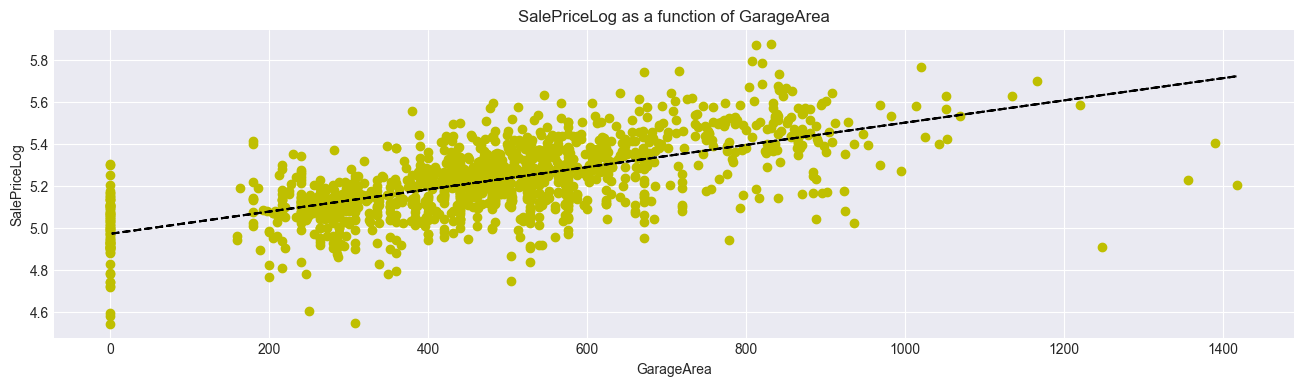

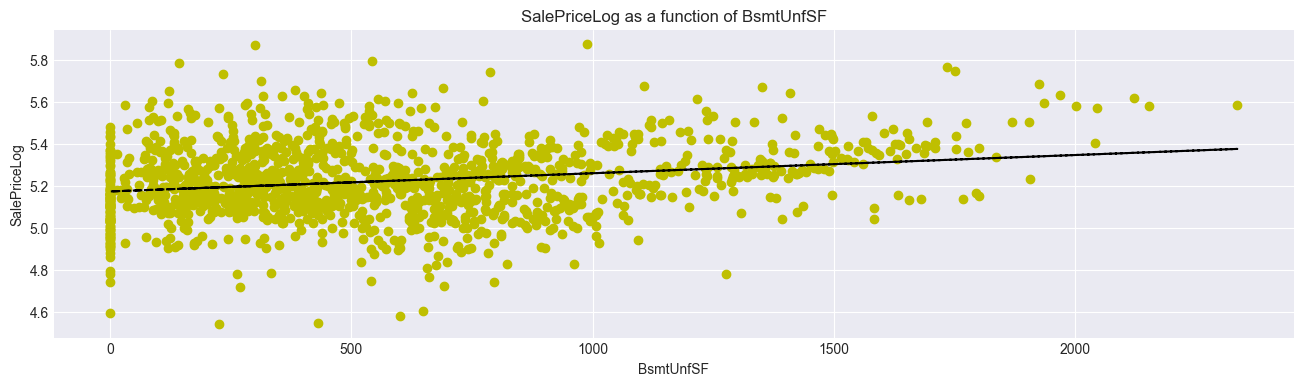

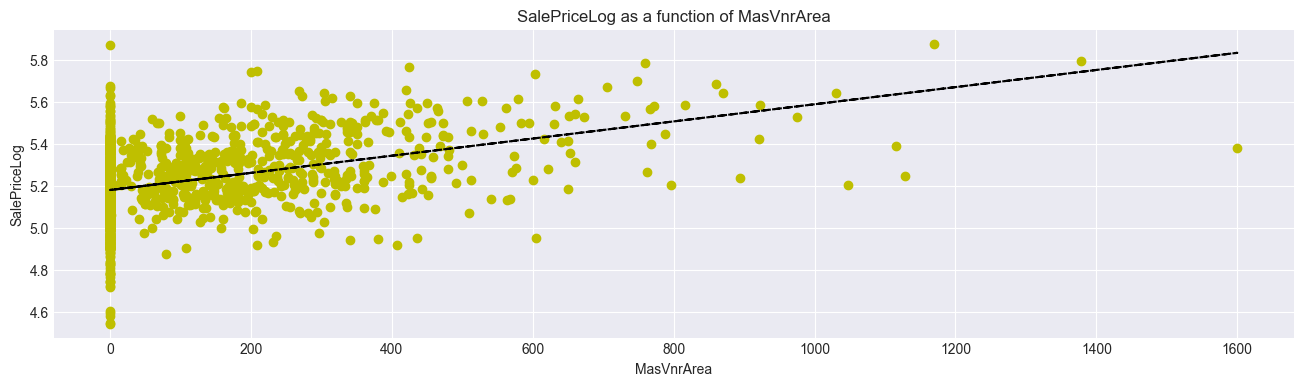

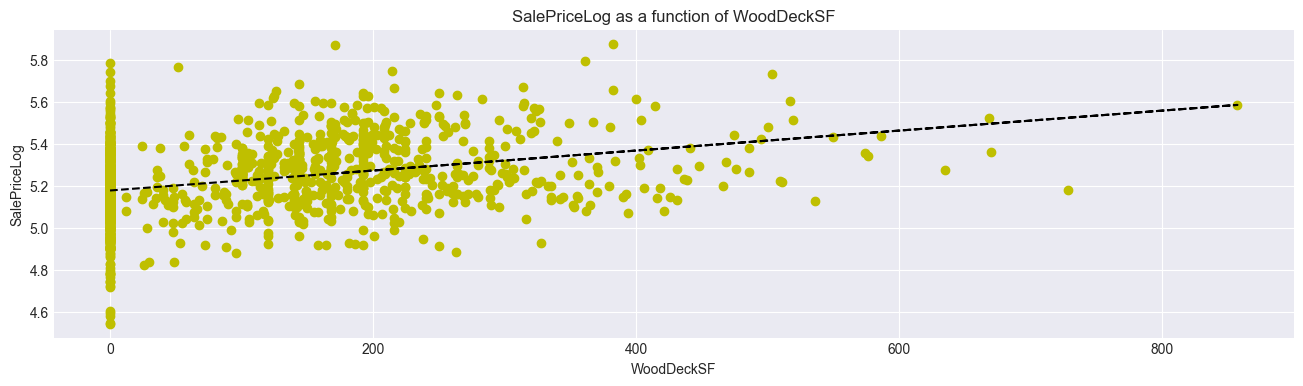

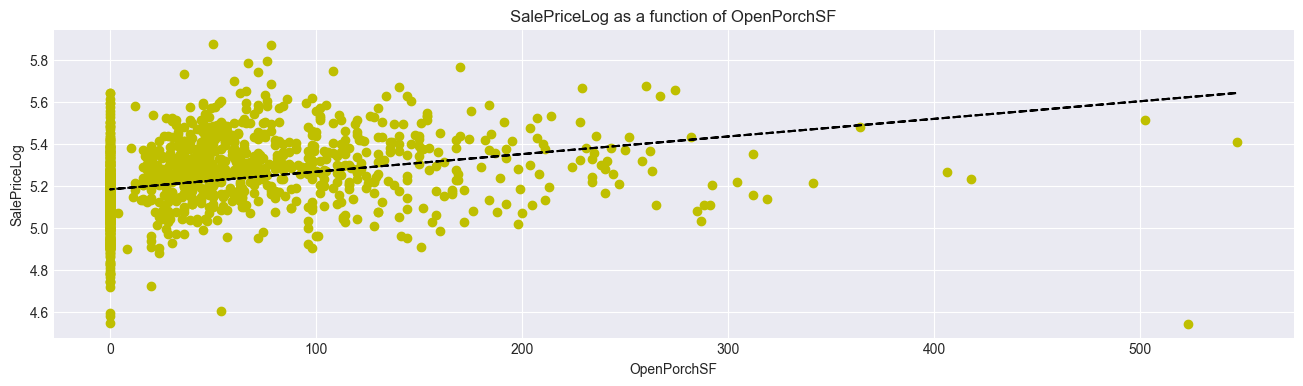

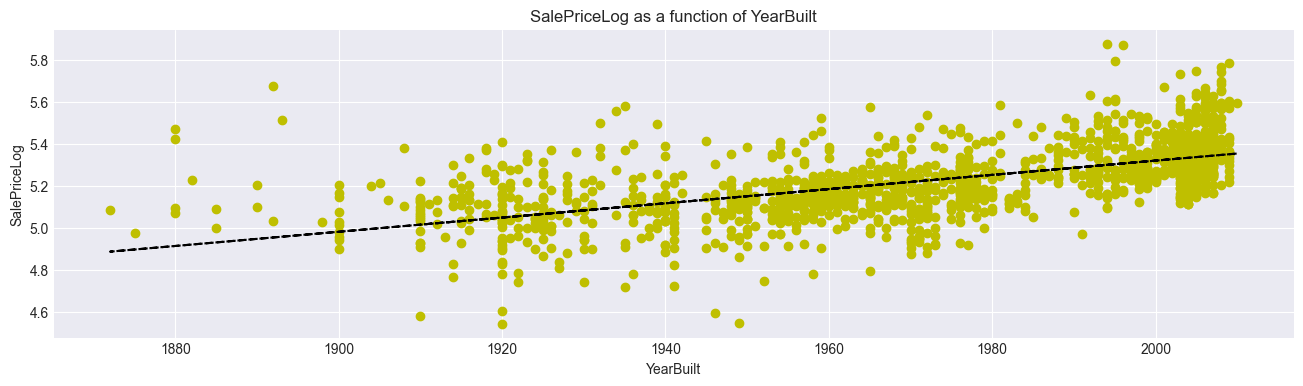

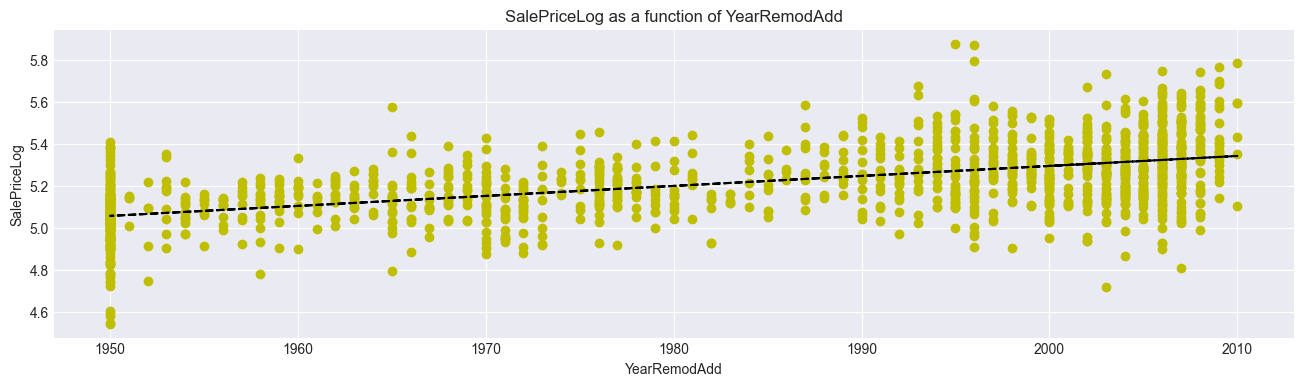

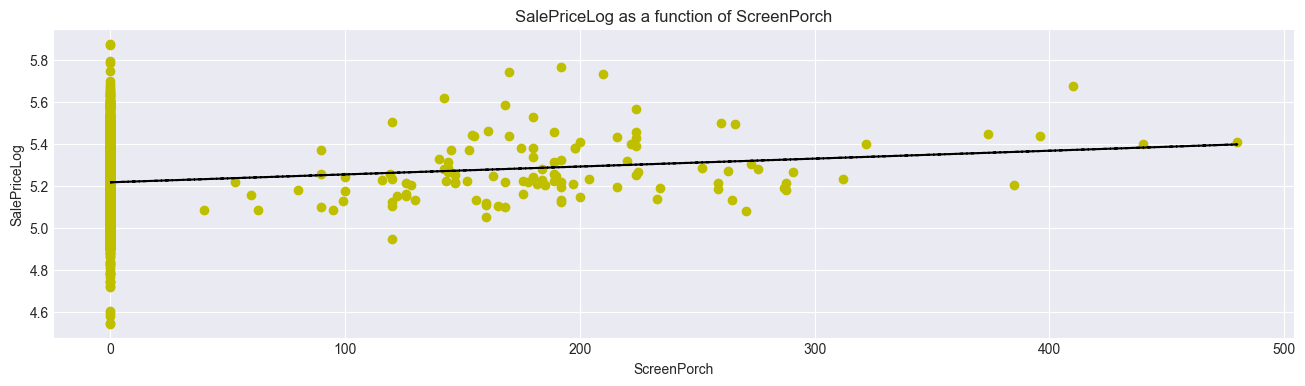

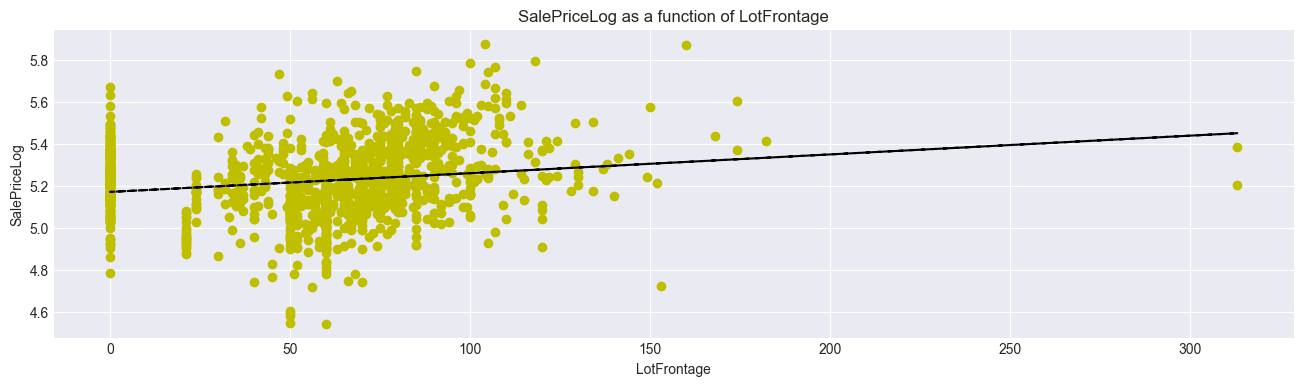

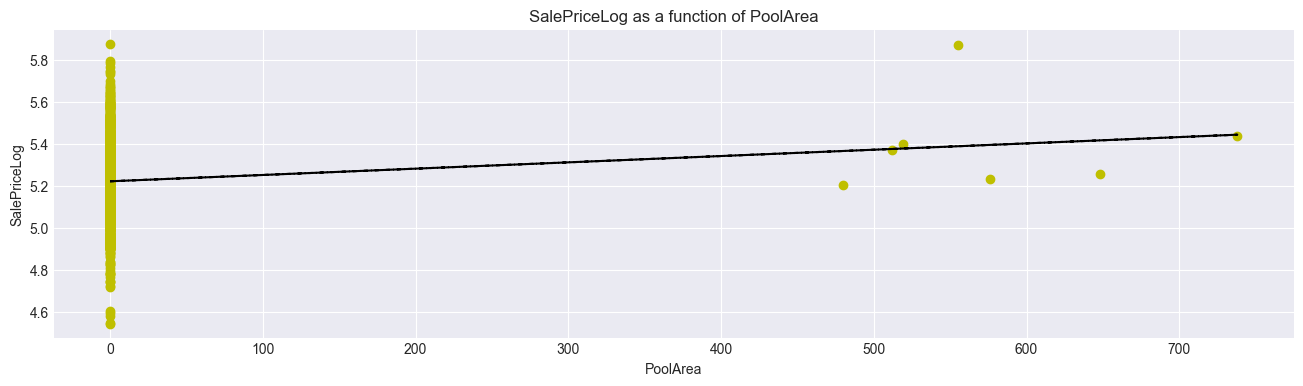

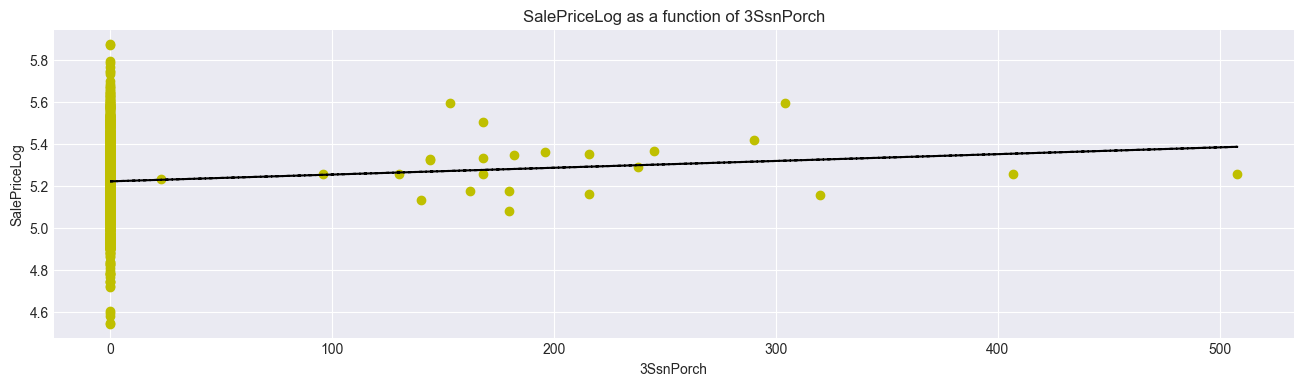

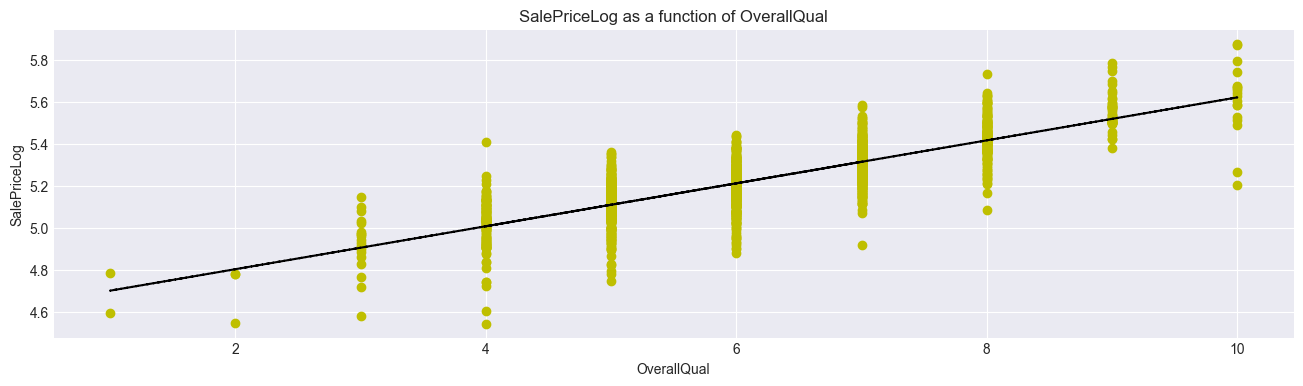

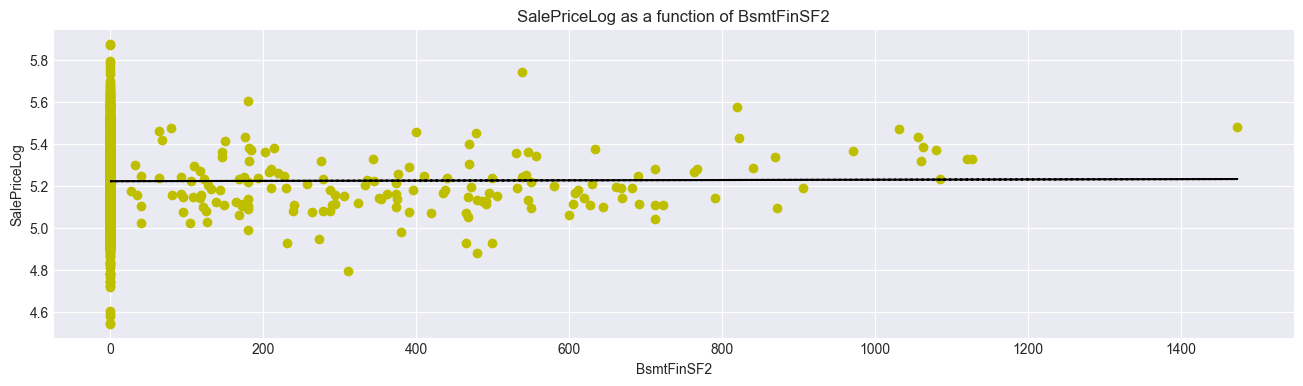

In [84]:
SalePriceLog = df_train_filled.SalePriceLog
df_train_numeric = df_train_filled._get_numeric_data().drop("SalePrice", axis=1)
price_cov_matrix = df_train_numeric.cov().SalePriceLog
price_cov = price_cov_matrix[price_cov_matrix >= 0.0]
price_cov = price_cov.sort_values(ascending=False)[:20]

for column in price_cov.index:
    x = df_train_filled[column]
    coef = numpy.polyfit(x, df_train_filled.SalePriceLog, 1)
    poly_1d_fn = numpy.poly1d(coef)

    plt.figure(figsize=(16,4))

    plt.plot(x, df_train_filled.SalePriceLog, "yo", x, poly_1d_fn(x), "--k")

    plt.xlabel(f"{column}")
    plt.ylabel("SalePriceLog")
    plt.title(f"SalePriceLog as a function of {column}")

    plt.grid(True)

plt.show()


- From the 20 relevant features extracted from the covariance matrix, it seems that GrLivArea,TotalBsmtSF, 1stFloorSF, BsmtFinSF1, GarageArea, BsmtUnfSF and YearBuilt seem to have the best linear correlations with SalePriceLog.

#### 8. Now, compute the correlation coefficient between `SalePriceLog` and every other relevant numerical variable. What are the 10 most correlated variables? Does the log transformation made to obtain `SalePriceLog` have any impact here?

In [111]:
column_param_list = {}

for column in price_cov.index:
    r_squared = numpy.corrcoef(df_train_numeric[column], df_train_numeric.SalePriceLog)[0,1].item()
    column_param_list[column] = r_squared
    
corr_series = pandas.Series(column_param_list).sort_values(ascending=False)[:10]
print("SalePriceLog Correlation Coefficients")
print(f"{corr_series}\n")

column_param_list = {}

for column in price_cov.index:
    r_squared = numpy.corrcoef(df_train_numeric[column], df_train_filled.SalePrice)[0,1].item()
    column_param_list[column] = r_squared
    
corr_series = pandas.Series(column_param_list).sort_values(ascending=False)[:10]
print("SalePrice Correlation Coefficients")
print(corr_series)


SalePriceLog Correlation Coefficients
OverallQual     0.817168
GrLivArea       0.700788
GarageArea      0.650865
TotalBsmtSF     0.612439
1stFlrSF        0.597110
YearBuilt       0.590704
YearRemodAdd    0.567227
MasVnrArea      0.426923
BsmtFinSF1      0.373768
GarageYrBlt     0.345385
dtype: float64

SalePrice Correlation Coefficients
OverallQual     0.790513
GrLivArea       0.708645
GarageArea      0.623577
TotalBsmtSF     0.613678
1stFlrSF        0.606136
YearBuilt       0.526092
YearRemodAdd    0.508104
MasVnrArea      0.472576
BsmtFinSF1      0.388074
WoodDeckSF      0.331155
dtype: float64


- Using a log scale does in fact make the R-Squared value be better.

#### 9. What categorical features seem to be least correlated with `SalePriceLog`? Use a suitable visualization strategy to gain insights.

Utilities        0.000161
LandSlope        0.001479
Street           0.003319
PoolQC           0.008189
MiscFeature      0.010747
Condition2       0.012126
RoofMatl         0.017996
LotConfig        0.023477
Functional       0.024504
LandContour      0.025792
Alley            0.027926
Heating          0.033198
BldgType         0.039205
Condition1       0.042809
Fence            0.043446
RoofStyle        0.043660
BsmtFinType2     0.043678
ExterCond        0.046230
BsmtCond         0.086750
LotShape         0.088380
PavedDrive       0.094050
Electrical       0.096805
HouseStyle       0.101670
SaleType         0.119417
CentralAir       0.124652
SaleCondition    0.126606
GarageQual       0.132978
GarageCond       0.142655
BsmtExposure     0.145732
Exterior2nd      0.174423
MSZoning         0.175904
Exterior1st      0.184393
MasVnrType       0.187630
BsmtFinType1     0.231618
HeatingQC        0.236264
Foundation       0.307160
FireplaceQu      0.309244
GarageType       0.332851
GarageFinish

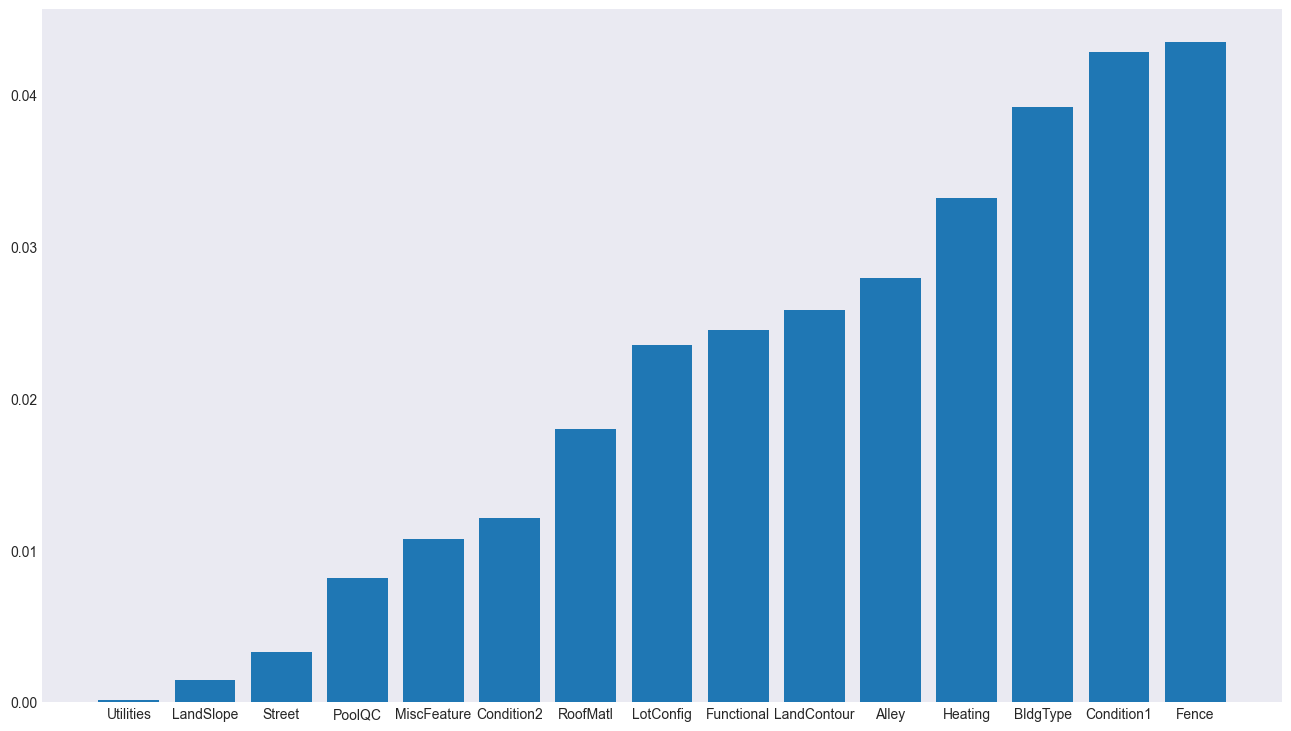

In [86]:
cate_col = df_train_filled.columns[~df_train_filled.columns.isin(df_train_numeric.columns)]
cate_df = df_train_filled[cate_col].drop("SalePrice", axis=1)

column_param_list = {}

for column in cate_df.columns:
    X = pandas.get_dummies(df_train_filled[column], drop_first=True).astype(int)
    X = sm.add_constant(X)

    Y = SalePriceLog
    result = sm.OLS(Y, X).fit()
    column_param_list[column] = result.rsquared.item()

corr_series = pandas.Series(column_param_list).sort_values()
print(corr_series)

plt.figure(figsize=(16,9))

plt.bar(corr_series.index[:15], corr_series.values[:15])

plt.show()


- From the plot shown and the list provided, it seems that not many categorical features are linearly correlated with `SalePriceLog`. However, of the features available, it can be inferred that `Utilities`, `LandSlope`, `Street` and `PoolQC` are particularly not very correlated at all.

#### 10. Apply PCA (with 2 and 3 components) to the dataset `df_train`, restricted to columns with numerical features not containing any missing value and excluding `Id`, `SalePrice` and `SalePriceLog`. Visualize the first 2 and 3 principal components. Does PCA give any insights on `SalePrice` (or its log transformation)? Use a suitable visualization strategy to address this question. Note that visualizations might be negatively impacted by outliers. If this is the case, try solutions to alleviate this issue.

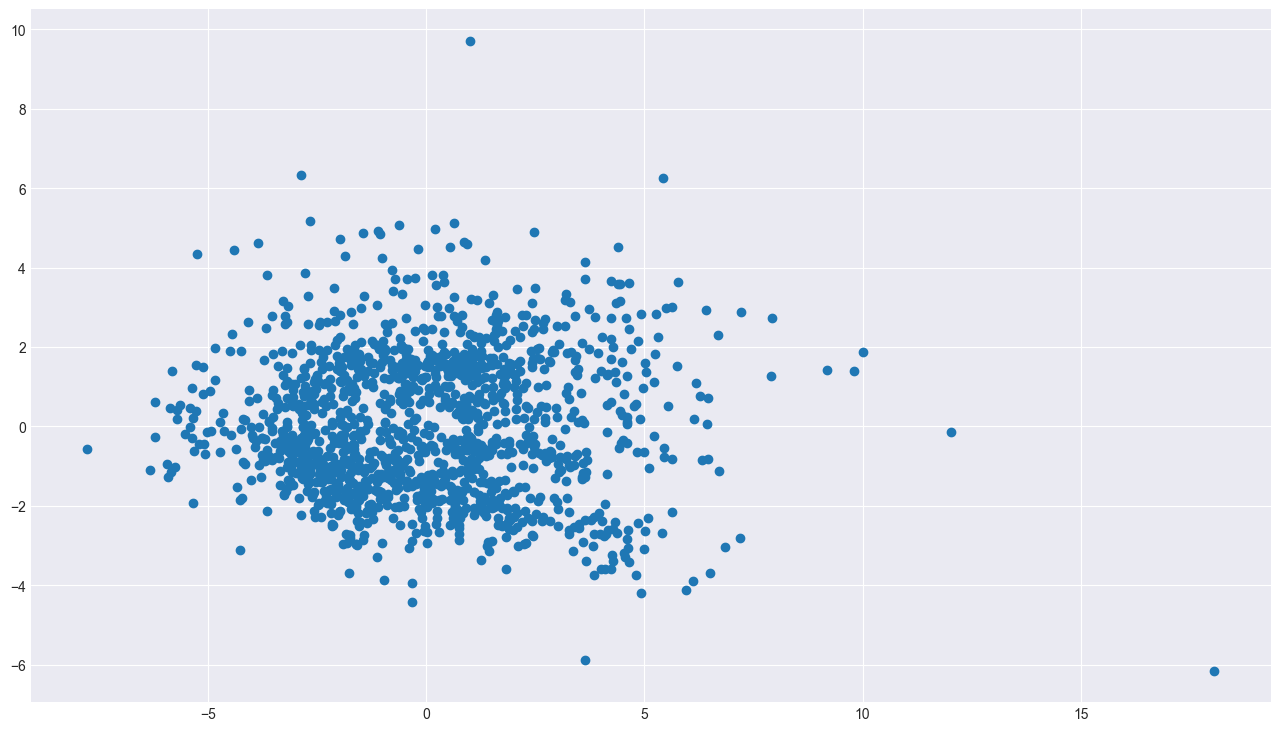

After 2 PCA, the SalePriceLog R-Squared is 0.7976


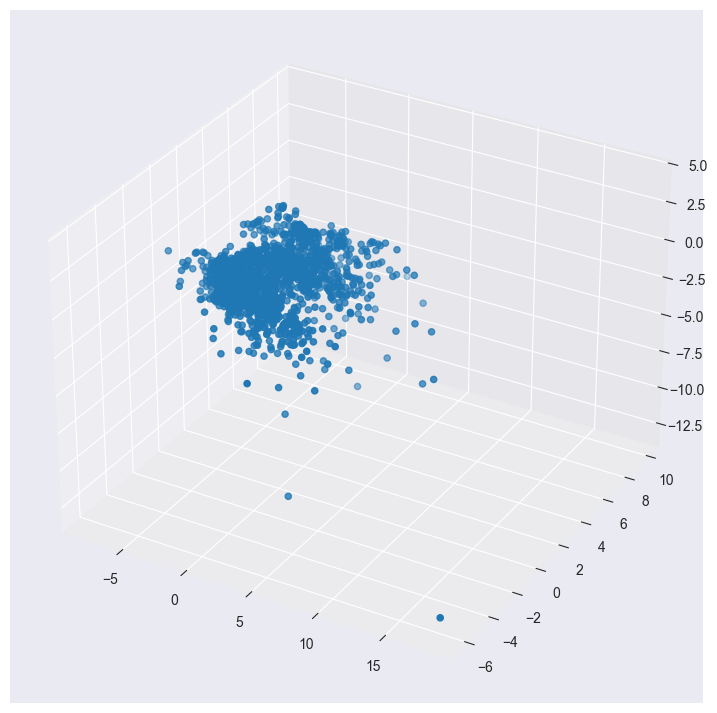

After 3 PCA, the SalePriceLog R-Squared is 0.7990


In [87]:
target = df_train_filled.SalePriceLog
scaled_df = StandardScaler().fit_transform(df_train_numeric.drop("SalePriceLog", axis=1), target)
two_pca_data = PCA(2, random_state=42).fit_transform(scaled_df)

plt.figure(figsize=(16,9))

plt.scatter(two_pca_data[:, 0], two_pca_data[:, 1])

plt.grid(True)

plt.show()

r_squared_2_pca = LinearRegression().fit(two_pca_data, target).score(two_pca_data, target)
print(f"After 2 PCA, the SalePriceLog R-Squared is {r_squared_2_pca:.4f}")

three_pca_data = PCA(3, random_state=42).fit_transform(scaled_df)

plt.figure(figsize=(16,9))

ax = plt.axes(projection="3d")

ax.scatter(three_pca_data[:, 0], three_pca_data[:, 1], three_pca_data[:,2])

plt.grid(True)

plt.show()

r_squared_3_pca = LinearRegression().fit(three_pca_data, target).score(three_pca_data, target)
print(f"After 3 PCA, the SalePriceLog R-Squared is {r_squared_3_pca:.4f}")




In [88]:
r_squared = LinearRegression().fit(scaled_df, target).score(scaled_df, target)
print(f"After 2 PCA, the SalePriceLog R-Squared is {r_squared:.4f}")


After 2 PCA, the SalePriceLog R-Squared is 0.8688


- PCA ended up causing a worse result for the regression model. This suggests that the dimensionality reduction ended up removing critical information. 

#### 11. In this exercise, we want to predict the sale price of houses in the dataset `house_test.csv`. With this aim, you are invited to test different regression methods among those we explored in class (and beyond, if you want to!). You can conduct further data explorations to select the most relevant regression variables, make suitable transformations, deal with outliers, select hyperparameters, apply for L1 or L2 constraints, cross-validation, deal with missing values, etc. Experiment with different techniques! Print the predicted prices for the 11 houses in `house_test.csv`. Note that you are invited to experiment with different methods, but you can propose only one set of predicted values for the test houses based on the method you deem most reliable. Marking will particularly take into account presentation quality, the justification of your choices, and the accuracy of your predictions (note that the test set does not contain `SalePrice`).

In [89]:
target = df_train_filled.SalePrice.astype(numpy.float32)

target_num_df = df_train_filled[df_train_filled.columns.intersection(["OverallQual","GrLivArea","GarageArea"])]

scaler = StandardScaler()
scaled_df = scaler.fit(target_num_df, target).transform(target_num_df)

target_cate_df = df_train_filled[["Neighborhood","ExterQual","BsmtQual"]]

for i, value in enumerate(target_cate_df.Neighborhood.unique()):
    target_cate_df.loc[target_cate_df.Neighborhood.__eq__(value), "Neighborhood"] = i + 1

for i, value in enumerate(["Po","Fa","TA","Gd","Ex"]):
    target_cate_df.loc[target_cate_df.ExterQual.__eq__(value), "ExterQual"] = i + 1

for i, value in enumerate(["NA","Po","Fa","TA","Gd","Ex"]):
    target_cate_df.loc[target_cate_df.BsmtQual.__eq__(value), "BsmtQual"] = i

train_data = numpy.hstack((scaled_df, target_cate_df.to_numpy(dtype=numpy.float32)))


C:\Users\Trim\AppData\Local\Temp\ipykernel_20120\2484955864.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_cate_df.loc[target_cate_df.Neighborhood.__eq__(value), "Neighborhood"] = i + 1
C:\Users\Trim\AppData\Local\Temp\ipykernel_20120\2484955864.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_cate_df.loc[target_cate_df.ExterQual.__eq__(value), "ExterQual"] = i + 1
C:\Users\Trim\AppData\Local\Temp\ipykernel_20120\2484955864.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [90]:
hyperparameters = {"alpha": [1e-4, 1e-3, 1e-2, 1e-1, 1.0, 10, 100]}

ridge_reg = Ridge(random_state=42)
grid_search = GridSearchCV(ridge_reg, hyperparameters, scoring="r2", cv=4)
grid_search.fit(train_data, target)

print(f"The best alpha hyperparameter is {grid_search.best_params_} at a R-Squared of {grid_search.best_score_:.4f}")


The best alpha hyperparameter is {'alpha': 10} at a R-Squared of 0.7632


The Linear Regression correlation coefficient is 0.7653


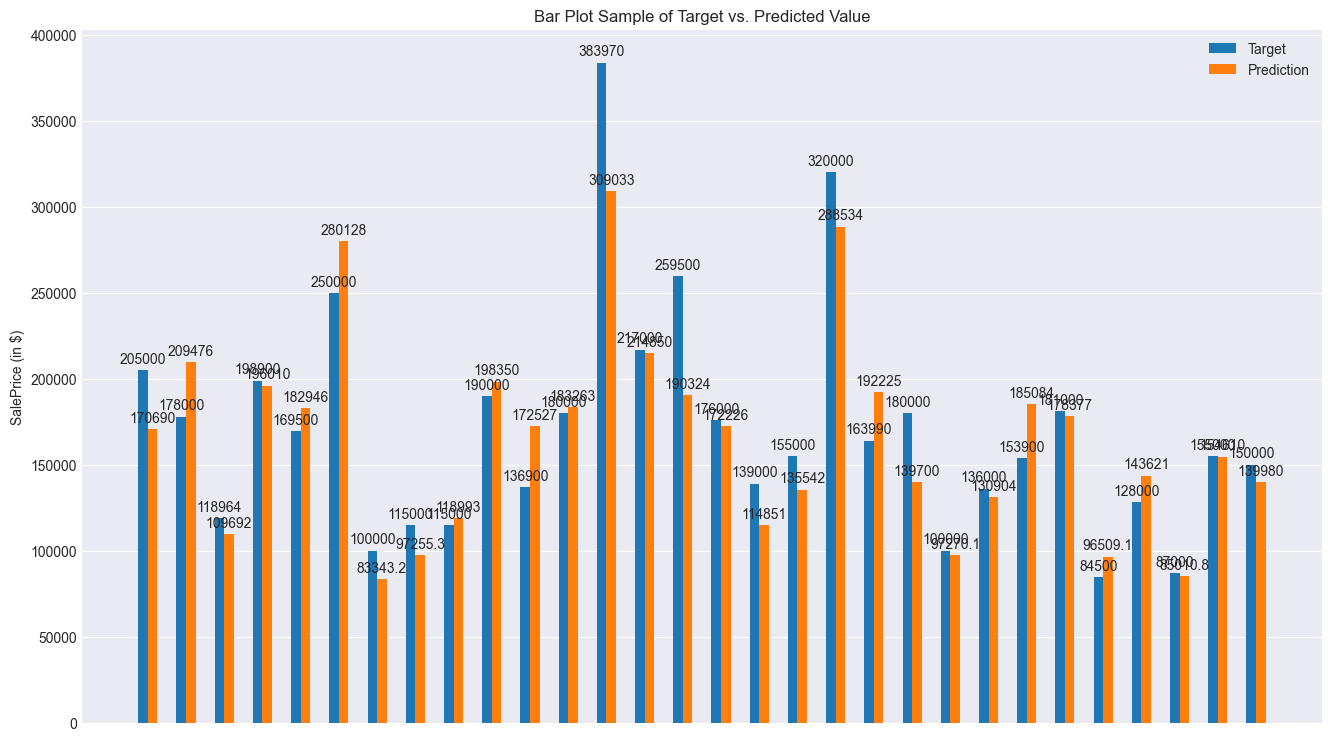

In [91]:
final_model = Ridge(alpha=grid_search.best_params_["alpha"], random_state=42)
final_model.fit(train_data, target)
predictions = final_model.predict(train_data)

print(f"The Linear Regression correlation coefficient is {final_model.score(train_data, target):.4f}")

target_sample = target[100:130]

predictions_sample = predictions[100:130]
samples = { "Target": target_sample, "Prediction": predictions_sample }

bar_width = 0.25

bar_multiplier = 0

fig, ax = plt.subplots(figsize=(16,9))

ticks = numpy.arange(len(target_sample))

for label, sample in samples.items():
    offset = bar_width * bar_multiplier
    rects = ax.bar(ticks + offset, sample, bar_width, label=label)
    ax.bar_label(rects, padding=3)
    bar_multiplier += 1

ax.set_ylabel("SalePrice (in $)")
ax.set_title("Bar Plot Sample of Target vs. Predicted Value")

ax.legend()
ax.grid(True)

ax.get_xaxis().set_visible(False)

plt.show()


In [92]:
test_df = pandas.read_csv("house_test.csv", index_col="Id")[target_num_df.columns.union(target_cate_df.columns)]

test_num_df = test_df[["OverallQual","GrLivArea","GarageArea"]]
scaled_test = scaler.transform(test_num_df)

test_cate_df = test_df[["Neighborhood","ExterQual","BsmtQual"]]

for i, value in enumerate(test_cate_df.Neighborhood.unique()):
    test_cate_df.loc[test_cate_df.Neighborhood.__eq__(value), "Neighborhood"] = i + 1

for i, value in enumerate(["Po","Fa","TA","Gd","Ex"]):
    test_cate_df.loc[test_cate_df.ExterQual.__eq__(value), "ExterQual"] = i + 1

for i, value in enumerate(["NA","Po","Fa","TA","Gd","Ex"]):
    test_cate_df.loc[test_cate_df.BsmtQual.__eq__(value), "BsmtQual"] = i

test_data = numpy.hstack((scaled_test, test_cate_df.to_numpy(dtype=numpy.float32)))


C:\Users\Trim\AppData\Local\Temp\ipykernel_20120\1647059042.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cate_df.loc[test_cate_df.Neighborhood.__eq__(value), "Neighborhood"] = i + 1
C:\Users\Trim\AppData\Local\Temp\ipykernel_20120\1647059042.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_cate_df.loc[test_cate_df.ExterQual.__eq__(value), "ExterQual"] = i + 1
C:\Users\Trim\AppData\Local\Temp\ipykernel_20120\1647059042.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [93]:
predictions = final_model.predict(test_data)

for i, price in enumerate(predictions):
    print(f"House {i + 1} SalePrice: {price:,.2f}$")


House 1 SalePrice: 87,006.30$
House 2 SalePrice: 147,011.89$
House 3 SalePrice: 259,049.48$
House 4 SalePrice: 140,619.19$
House 5 SalePrice: 112,699.97$
House 6 SalePrice: 197,323.43$
House 7 SalePrice: 183,205.72$
House 8 SalePrice: 207,471.79$
House 9 SalePrice: 256,136.22$
House 10 SalePrice: 112,711.53$
House 11 SalePrice: 145,891.83$


- The following data preparations were done to derive the model
    - Apply standardization to the numerical data for faster convergence
    - Fill in missing values for selected all features to provide more rich data
    - Select relevant features based on covariance for numeric data and R-Squared scores for categorical data to remove redundancies
    - Utilize cross validation and hyperparameter tuning to justify final model predictions based on R-Squared scores
    - Utilize Ridge Regression to impose penalties on weight energies from OLS

- With this approach the model can give out reasonable estimations on the SalePrice of the homes as shown in the plot above.